In [1]:
%reset -f

In [2]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import datetime as DT
import pandas as pd
import math
import scipy as sp
import datetime
from IPython.core.debugger import Tracer
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.classification import log_loss

from sklearn import datasets, linear_model
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

%matplotlib inline
import seaborn as sns; sns.set()
import operator
import itertools
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr
import scipy

import utils as ut
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Load in new data set and get an idea of dimensions
## 1) load data

In [5]:
def coltodatetime(df, col):
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
def splitcol(df, col, char):
    df[col] =df[col].fillna('')
    r = df[col].apply(lambda x: pd.Series(x.split(char)))
    for i in range(0, r.shape[1]):
        df[col + str(i)] = r[i]
    #del df[col]
def combinedatentime(df, datecol, timecol, newcol):
    df[newcol] = df.apply(lambda row: datetime.datetime.combine(row[datecol].date(), row[timecol].time()), axis=1) 


In [6]:
f1 = "C:/Users/lloyd/data/LFB incident data 1 Jan 2009 to 31 Aug 2015/LFB incident data 1 Jan 2009 to 31 Dec 2011.csv"

df = pd.read_csv(f1, header=0, nrows = 100000)
#df = pd.read_csv(f1, header=0, nrows = 150, infer_datetime_format=True)
#df = df.convert_objects(convert_numeric=True)
coltodatetime(df, "DateOfCall")
coltodatetime(df, "TimeOfCall")
splitcol(df, "Postcode_full", ' ')
combinedatentime(df, "DateOfCall", "TimeOfCall", "DatetimeOfCall")
df['hour'] = df["DatetimeOfCall"].apply(lambda x : x.hour)
df['month'] = df["DatetimeOfCall"].apply(lambda x : x.month)
df['weekday'] = df["DatetimeOfCall"].apply(lambda x : x.weekday())
print("Dataframe shape")
print(df.shape)
print("Columns")
print(df.dtypes)
print("Samples")
ut.dispdf(df,5)

Dataframe shape
(100000, 33)
Columns
IncidentNumber                                     int64
DateOfCall                                datetime64[ns]
TimeOfCall                                datetime64[ns]
IncidentGroup                                     object
StopCodeDescription                               object
SpecialServiceType                                object
PropertyCategory                                  object
PropertyType                                      object
AddressQualifier                                  object
Postcode_full                                     object
Postcode_district                                 object
IncGeo_BoroughCode                                object
IncGeo_BoroughName                                object
IncGeo_WardCode                                   object
IncGeo_WardName                                   object
Easting_m                                        float64
Northing_m                                       fl

IncidentNumber DateOfCall          TimeOfCall    IncidentGroup  \
0       235138081 2009-01-01 2017-01-24 00:00:37  Special Service   
1            1091 2009-01-01 2017-01-24 00:00:46  Special Service   
2            2091 2009-01-01 2017-01-24 00:03:00             Fire   
3            3091 2009-01-01 2017-01-24 00:04:27             Fire   
4            5091 2009-01-01 2017-01-24 00:05:39             Fire   

  StopCodeDescription  
0     Special Service  
1     Special Service  
2      Secondary Fire  
3      Secondary Fire  
4      Secondary Fire

SpecialServiceType PropertyCategory  \
0                    RTC     Road Vehicle   
1  Assist other agencies          Outdoor   
2                    NaN          Outdoor   
3                    NaN          Outdoor   
4                    NaN          Outdoor   

                                  PropertyType  \
0                                         Car    
1                         Lake/pond/reservoir    
2                       Road surface/pavement    
3  Domestic garden (vegetation not equipment)    
4        Cycle path/public footpath/bridleway    

                              AddressQualifier Postcode_full  
0                           In street close to      SW11 4LB  
1  Open land/water - nearest address to access       SE1 7SG  
2                            In street outside        N9 9EL  
3             On land associated with building      UB10 0DG  
4                            In street outside        N7 8HG

Postcode_district IncGeo_BoroughCode IncGeo_BoroughName IncGeo_WardCode  \
0              SW11          E09000032         Wandsworth       E05000620   
1               SE1          E09000022            Lambeth       E05000416   
2                N9          E09000010            Enfield       E05000201   
3              UB10          E09000017         Hillingdon       E05000332   
4                N7          E09000019          Islington       E05000375   

   IncGeo_WardName  
0       Queenstown  
1         Bishop's  
2        Haselbury  
3  Hillingdon East  
4         Holloway

Easting_m  Northing_m  Easting_rounded  Northing_rounded     FRS
0   528652.0    176830.0           528650            176850  London
1   530485.0    179007.0           530450            179050  London
2   533773.0    194492.0           533750            194450  London
3   507738.0    182805.0           507750            182850  London
4   531058.0    185307.0           531050            185350  London

IncidentStationGround  FirstPumpArriving_AttendanceTime  \
0             Battersea                             319.0   
1               Lambeth                               NaN   
2              Edmonton                             308.0   
3            Hillingdon                             210.0   
4              Holloway                             233.0   

  FirstPumpArriving_DeployedFromStation  SecondPumpArriving_AttendanceTime  \
0                             Battersea                              342.0   
1                                   NaN                                NaN   
2                              Edmonton                                NaN   
3                            Hillingdon                                NaN   
4                              Holloway                              250.0   

  SecondPumpArriving_DeployedFromStation  
0                                Clapham  
1                                    NaN  
2                                    NaN  
3                                    NaN  
4                               Holloway

NumStationsWithPumpsAttending  NumPumpsAttending Postcode_full0  \
0                            2.0                2.0           SW11   
1                            NaN                NaN            SE1   
2                            1.0                1.0             N9   
3                            1.0                1.0           UB10   
4                            1.0                2.0             N7   

  Postcode_full1      DatetimeOfCall  
0            4LB 2009-01-01 00:00:37  
1            7SG 2009-01-01 00:00:46  
2            9EL 2009-01-01 00:03:00  
3            0DG 2009-01-01 00:04:27  
4            8HG 2009-01-01 00:05:39

hour  month  weekday
0     0      1        3
1     0      1        3
2     0      1        3
3     0      1        3
4     0      1        3

## 2) figure out primary key

In [7]:
def isunique(df, col):
    return  len(df[col]) ==  len(set(df[col]))

In [8]:
print("IsUnique ", isunique(df, "IncidentNumber"))

IsUnique  True


## 3) figure out what types of columns you have, numerical, categorical and nlp

In [9]:
def splitcoltypes(df):
    numcols = []
    datcols = []
    catcols = []
    for i in range(len(df.columns)):
        if(df.dtypes[i] == "object"):
            catcols.append(df.columns[i])
        elif(df.dtypes[i] == "datetime64[ns]"):
            datcols.append(df.columns[i])
        else:
            numcols.append(df.columns[i])
    return numcols, datcols, catcols

In [10]:
numcols, datcols, catcols = splitcoltypes(df)
print("Numerical Columns", len(numcols))
print(numcols, "\n")
print("Datetime Columns", len(datcols))
print(datcols, "\n")
print("Categorical Columns", len(catcols))
print(catcols, "\n")

Numerical Columns 12
['IncidentNumber', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', 'FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'hour', 'month', 'weekday'] 

Datetime Columns 3
['DateOfCall', 'TimeOfCall', 'DatetimeOfCall'] 

Categorical Columns 18
['IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'IncGeo_WardCode', 'IncGeo_WardName', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_DeployedFromStation', 'Postcode_full0', 'Postcode_full1'] 



## 4) deal with numerical
- 4a) for each column, min, max, count, missing, types

In [11]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def colstats(df, c):
    vals = df[c]
    count = len(vals)
    min = np.min(vals)
    max = np.max(vals)
    per_25 = np.percentile(vals, 25)
    mean = np.mean(vals)
    per_75 = np.percentile(vals, 75)
    std = np.std(vals)
    #expected 3
    kurt = sp.stats.kurtosis(vals)
    skew = sp.stats.skew(vals)
    nans = vals.isnull().sum()
    per_nans = nans/count * 100
    out_num = len(df[c][mad_based_outlier(df[c].values)])
    out_per = out_num/count * 100

    d = {"count": count, "min": min, "max": max, "per_25": per_25, "mean": mean,
         "per_75": per_75, "std": std, "kurt": kurt, "skew": skew, "nans": nans, 
         "nans_per": per_nans, "out_num": out_num, "out_per": out_per
        }
    
    st = pd.DataFrame.from_dict(d, orient='index')
    st.rename(columns={0: c }, inplace=True)
    st.sort_index(inplace=True)
    return st

def catstats(df, c):
    vc = df[c].value_counts()
    count = len(vc)

    d = {"catcount": count, 
        }
    
    st = pd.DataFrame.from_dict(d, orient='index')
    st.rename(columns={0: c }, inplace=True)
    st.sort_index(inplace=True)
    return st


def removenans(df, c):
    return df.dropna(subset=[c])

def dataframestats(df):
    stats = pd.DataFrame()
    for c in df.columns:
        if(not df[c].dtype == "object" and not df[c].dtype == "datetime64[ns]"):
            st = colstats(df, c)
            stats[c] = st[c]
    return stats

def dataframecatstats(df_local):
    stats = pd.DataFrame()
    for c in df_local.columns:
        if(not df_local[c].dtype == 'float64' and not df_local[c].dtype == 'int64'):
            print(df_local.shape)
            st = catstats(df_local, c)
            stats[c] = st[c]
    return stats

In [12]:
print(df.shape)


(100000, 33)


- 4b) shapes of distribution
- 4c) fill in missing values/drop them

In [13]:
#dist functions
def showdist(df, c, threshold=3.5):
    ut.figurefullwidth()
    nans = df[c].isnull().sum()
    vals = df[c].dropna().values
    ut.subplottitle(1, "Nans", w=6)
    plt.bar([1, 2], [len(df[c])-nans,nans], tick_label = ["Ok", "NaN"])
    ut.subplottitle(2, "Hist", w=6)
    plt.hist(vals, bins=20)
    ut.subplottitle(3, "Plot", w=6)
    plt.plot(vals, 'o')
    ut.subplottitle(4, "Box", w=6)
    sns.boxplot(vals)
    outliers = mad_based_outlier(df[c].values)
    outpoints = df[c][outliers]
    ut.subplottitle(5, "Distplot", w=6)
    sns.distplot(df[c], bins=20, hist=False)
    ut.subplottitle(6, "Outliers", w=6)
    plt.plot(outpoints, 'ro')
    out_per = (len(outpoints)/df.shape[0])*100
    nan_per = (nans/df.shape[0])*100
    print(c,df.shape,"Ouliers", len(outpoints), "{:1.2f}".format(out_per),"%","Nans",nans, "{:1.2f}".format(nan_per),"%","\n")
    plt.show()
    
def examineonenumcol(df, c):
    showdist(df, c)
    #df2 = removeoutliers(df, c)
    #chg = df2.shape[0] - df.shape[0]
    #chg_per = chg / df.shape[0] * 100.0
    #print(c, "After",df2.shape,chg, "{:10.2f}".format(chg_per) + "%", "\n")
    #showdist(df2, c)

def removeoutliers(df, c, threshold=3.5):
    outliers = mad_based_outlier(df[c].values)
    outpoints = df[c][outliers]
    return df.drop(outpoints.index)

def removeoutliersfromcols(df, cols, threshold=3.5):
    print("#===============================================")
    print("# Remove outliers from", cols)
    print("#===============================================")

    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            df2 = removeoutliers(df2, c)
    return df2

def removecols(df, cols):
    print("#===============================================")
    print("# Remove cols ", cols)
    print("#===============================================")
    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            df2 = df2.drop(c, axis=1)
    return df2
def removenansfromcols(df, cols):
    print("#===============================================")
    print("# Remove nan from cols ", cols)
    print("#===============================================")
    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            val_list = df2[df2[c].apply(lambda x: np.isnan(x))]
            print(len(val_list))
            df2 =df2.drop(val_list.index)
    return df2
def makenormalfromexp(df, cols):
    print("#===============================================")
    print("# make normal from exp", cols)
    print("#===============================================")
    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            df2[c] = df2[c].apply(lambda x: 1/x)
    return df2
def makenormalfromlog(df, cols):
    print("#===============================================")
    print("# make normal from lognormal", cols)
    print("#===============================================")
    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            df2[c] = df2[c].apply(lambda x: np.log(x))
    return df2

## Main area for adding / removing columns and transforming data

In [14]:
def dispcatdata(df, c):
    vc = df[c].value_counts()
    print(c, " counttypes ",vc.shape[0],  "\n")
    if(vc.shape[0] > 100):
        print("Data is large!!!!!!!!!!!! " , vc.shape[0])
    cumsum = np.cumsum(vc.values)
    cumsum = cumsum/len(df[c])
    if False:
        ut.subplottitle(1, "CumSum")
        plt.plot(cumsum)
    #print(vc)
    ut.figurefullwidth()
    vc[:100].plot(kind='bar')
    plt.show()
    pro = 0;
    for n in vc.values:
        pro
    
def sigvals(df, c, threshold=0.8, num=0):
    print(df.columns, c)
    vc = df[c].value_counts()
    names = vc.index.tolist()
   
    count = len(df[c])
    cutoff = (int)(count * threshold)
    acc = 0
    num_acc = 0;
    ret = []
    others = []
    for i in range(vc.shape[0]):
        #print(names[i])
        if acc < cutoff and num_acc < num -1:
            ret.append(names[i])
        else:
            others.append(names[i])
        acc += vc[i]
        num_acc += 1
    return ret, others


def filteronsig(df, cols, threshold=0.8, num=0):
    df2 = df.copy(deep=True)
    for c in cols:
        #print(c)
        sig, others = sigvals(df2, c, threshold=threshold, num=num)
        df2[c] = df2[c].apply(lambda x: x if x in sig else "other")
    return df2

def examineonecatcol(df_local, c, threshold):
    df_temp = filteronsig(df_local, [c], threshold=threshold)
    diff = df_local.shape[0] - df_temp.shape[0]
    print(df_temp.shape, diff, "{:1.2f}".format(diff/df_local.shape[0]*100), "% elements in bottom ", "{:1.2f}".format((1-threshold)*100), "% of categories")
    dispcatdata(df_local, c)

In [17]:
onehotencodings = {}
def onehotencode(df, cols):
    for c in cols:
        if(c in df.columns):
            pre_cols = df.columns
            temp_col = df[c]
            df = pd.get_dummies(df, columns=[c])
            df[c] = temp_col
            post_cols = df.columns
            diff_cols = list(set(post_cols) - set(pre_cols))
            onehotencodings[c] = diff_cols
    return df
   
#dummyencodings = {}
#def dummyencode(df2, col):
#    if(df2[c].dtype == "object"):
#        le = LabelEncoder()
#        df2[c] = df2[c].apply(lambda x: 'NaN' if pd.isnull(x) else x)
#        df2[c] = le.fit_transform(df2[c])
#        encodings[c] = le
#    return df

def encodecols(df, catcols, dummy=False):
    df2 = df.copy(deep=True)
#    if(dummy):
#        for c in catcols:
#            if(c in df2.columns):
#                df2 = dummyencode(df2, c)
#    else:
    df2 = onehotencode(df2, catcols)
    return df2

def printencodings(catcols):
    tenc1 = pd.DataFrame()
    for c in catcols:
        if(c in onehotencodings):
            classes = onehotencodings[c]
            tenc = pd.DataFrame(classes, index = range(len(classes)))
            tenc[c] = tenc[0]
            del tenc[0]
            ut.dispdf(tenc, num=10)


Numerical columns
['IncidentNumber', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', 'FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'hour', 'month', 'weekday']
Categorical columns
['IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'IncGeo_WardCode', 'IncGeo_WardName', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_DeployedFromStation', 'Postcode_full0', 'Postcode_full1']
#===============================================
# Remove nan from cols  ['FirstPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending', 'NumPumpsAttending']
#===============================================
7710
0
0
#===============================================
# make normal from lognormal ['FirstPumpArriving_AttendanceTi

12

IncidentNumber  Easting_rounded  Northing_rounded  \
count       9.131800e+04     91318.000000      91318.000000   
kurt       -1.210208e+00         0.132866          0.076848   
max         2.351381e+08    559350.000000     200950.000000   
mean        8.424562e+07    530750.009856     180585.366521   
min         1.092000e+03    504150.000000     159350.000000   
nans        0.000000e+00         0.000000          0.000000   
nans_per    0.000000e+00         0.000000          0.000000   
out_num     0.000000e+00         0.000000          0.000000   
out_per     0.000000e+00         0.000000          0.000000   
per_25      4.014059e+07    525450.000000     176550.000000   
per_75      1.282448e+08    536350.000000     184950.000000   
skew        5.662836e-02        -0.163404         -0.234328   
std         5.027473e+07      9746.399042       7108.203707   

          FirstPumpArriving_AttendanceTime  NumStationsWithPumpsAttending  
count                         91318.000000                   91318.000000  
kurt                              0.291844                      39.977592  
max                               7.022868                      21.000000  
mean                              5.727914                       1.328949  
min                               4.406719                       1.000000  
nans                              0.000000                       0.000000  
nans_per                          0.000000                       0.000000  
out_num                          35.000000                   26132.000000  
out_per                           0.038328                      28.616483  
per_25                            5.472271                       1.000000  
per_75                            5.971262                       2.000000  
skew                              0.150773                       3.171779  
std                               0.391075                       0.583467

NumPumpsAttending          hour         month       weekday
count          91318.000000  91318.000000  91318.000000  91318.000000
kurt              60.804133     -0.589180     -1.181016     -1.261946
max               31.000000     23.000000      9.000000      6.000000
mean               1.580510     13.652894      4.956810      2.993725
min                1.000000      0.000000      1.000000      0.000000
nans               0.000000      0.000000      0.000000      0.000000
nans_per           0.000000      0.000000      0.000000      0.000000
out_num        39329.000000      0.000000      0.000000      0.000000
out_per           43.068179      0.000000      0.000000      0.000000
per_25             1.000000     10.000000      3.000000      1.000000
per_75             2.000000     19.000000      7.000000      5.000000
skew               3.441416     -0.520604     -0.038807     -0.003543
std                0.812725      6.217844      2.507938      2.000644

IncidentNumber (91318, 22) Ouliers 0 0.00 % Nans 0 0.00 % 



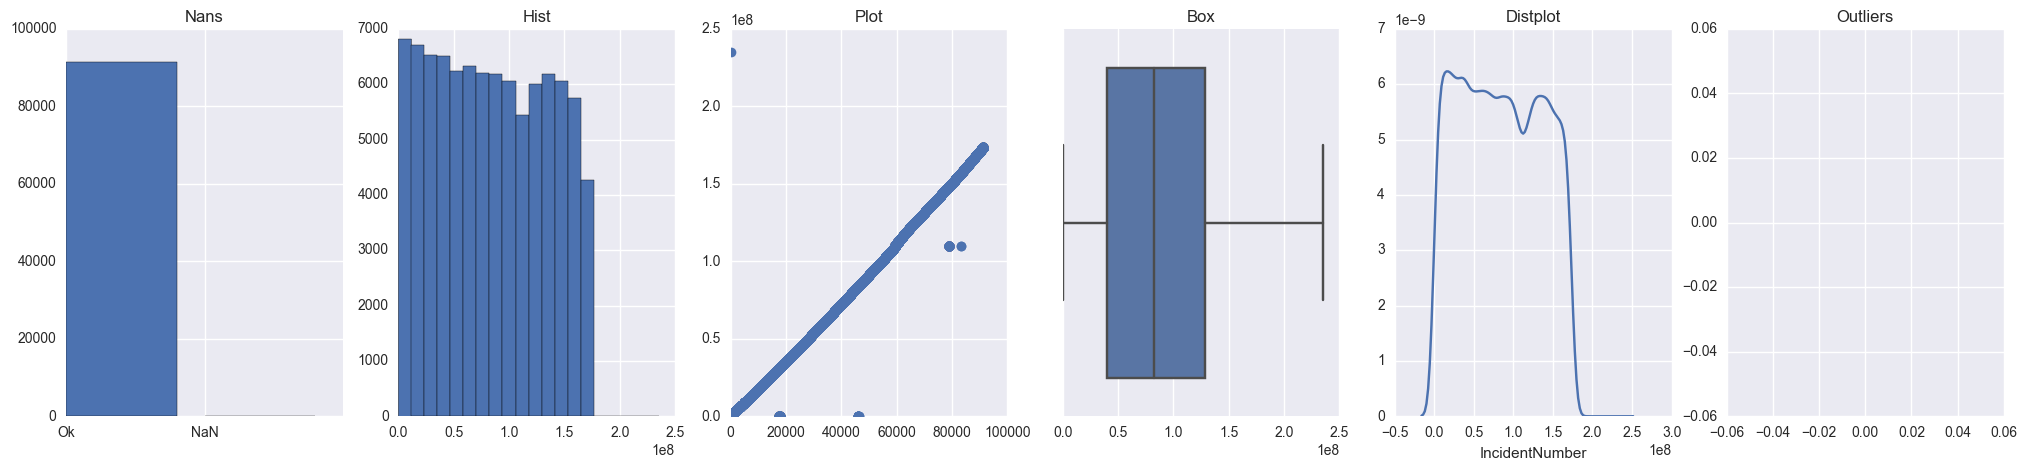

Easting_rounded (91318, 22) Ouliers 0 0.00 % Nans 0 0.00 % 



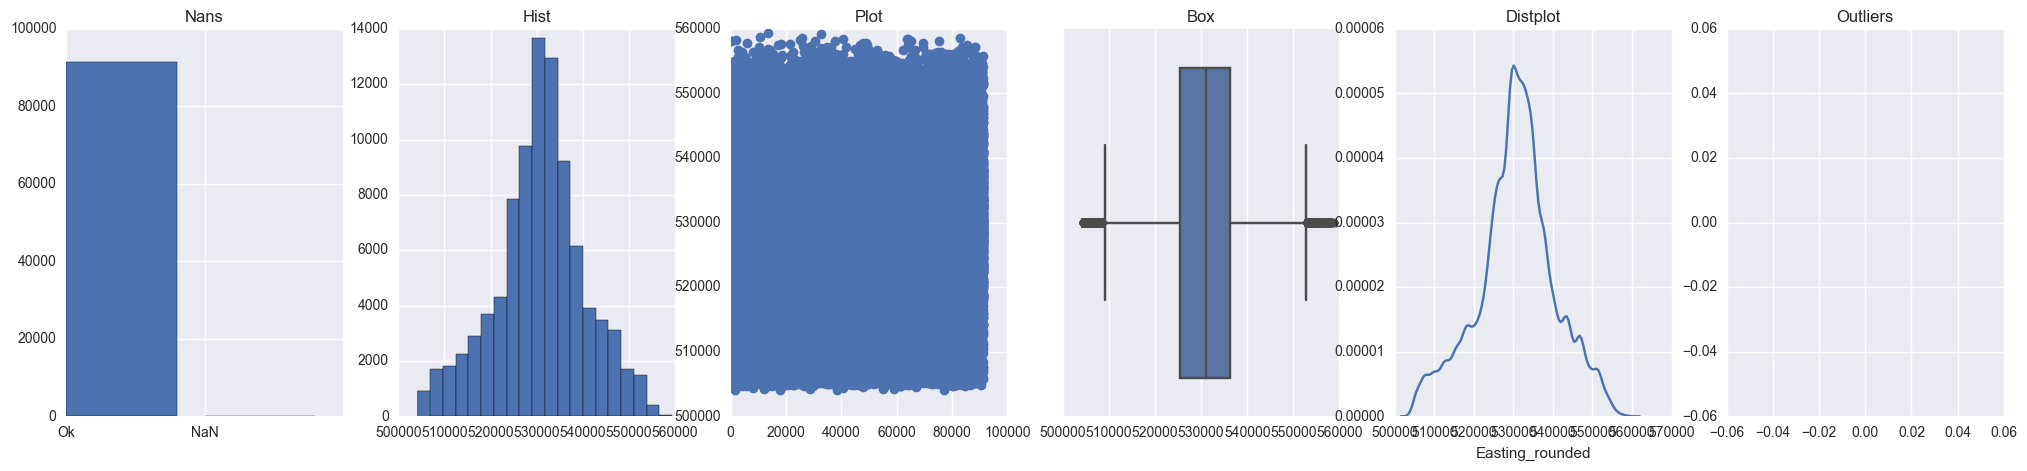

Northing_rounded (91318, 22) Ouliers 0 0.00 % Nans 0 0.00 % 



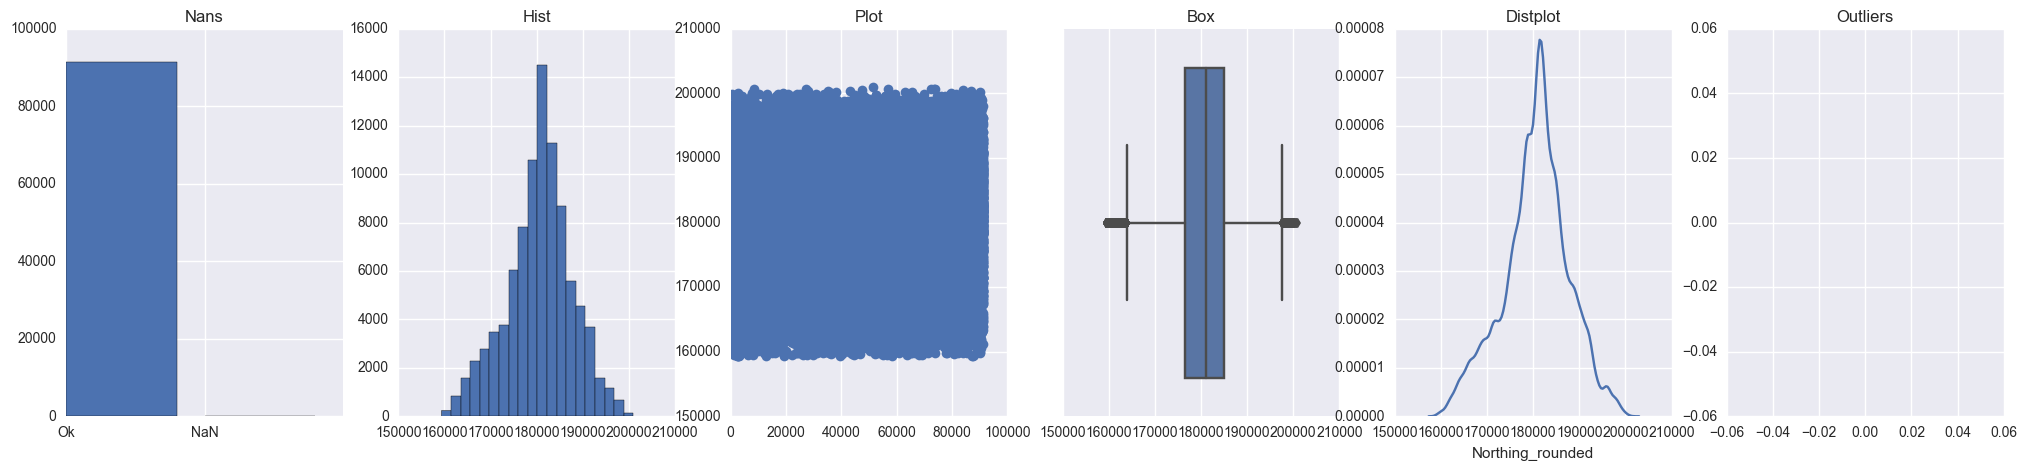

FirstPumpArriving_AttendanceTime (91318, 22) Ouliers 35 0.04 % Nans 0 0.00 % 



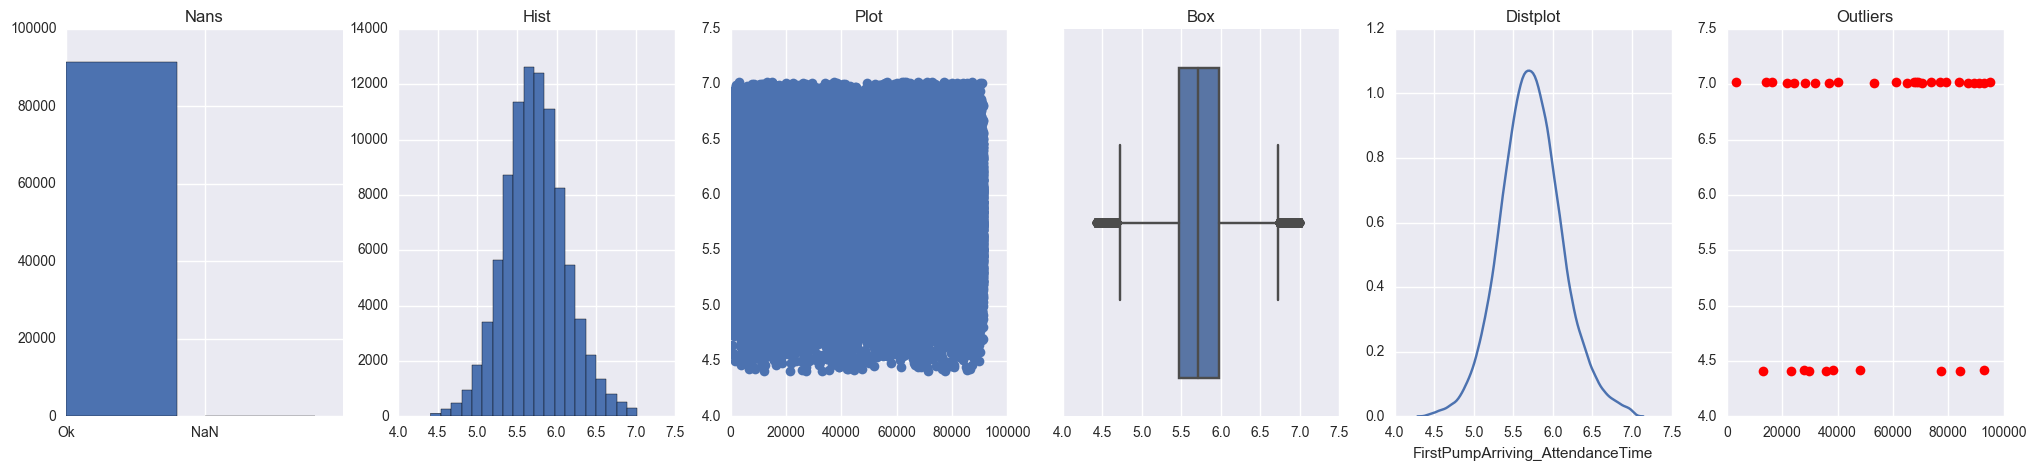

NumStationsWithPumpsAttending (91318, 22) Ouliers 26132 28.62 % Nans 0 0.00 % 



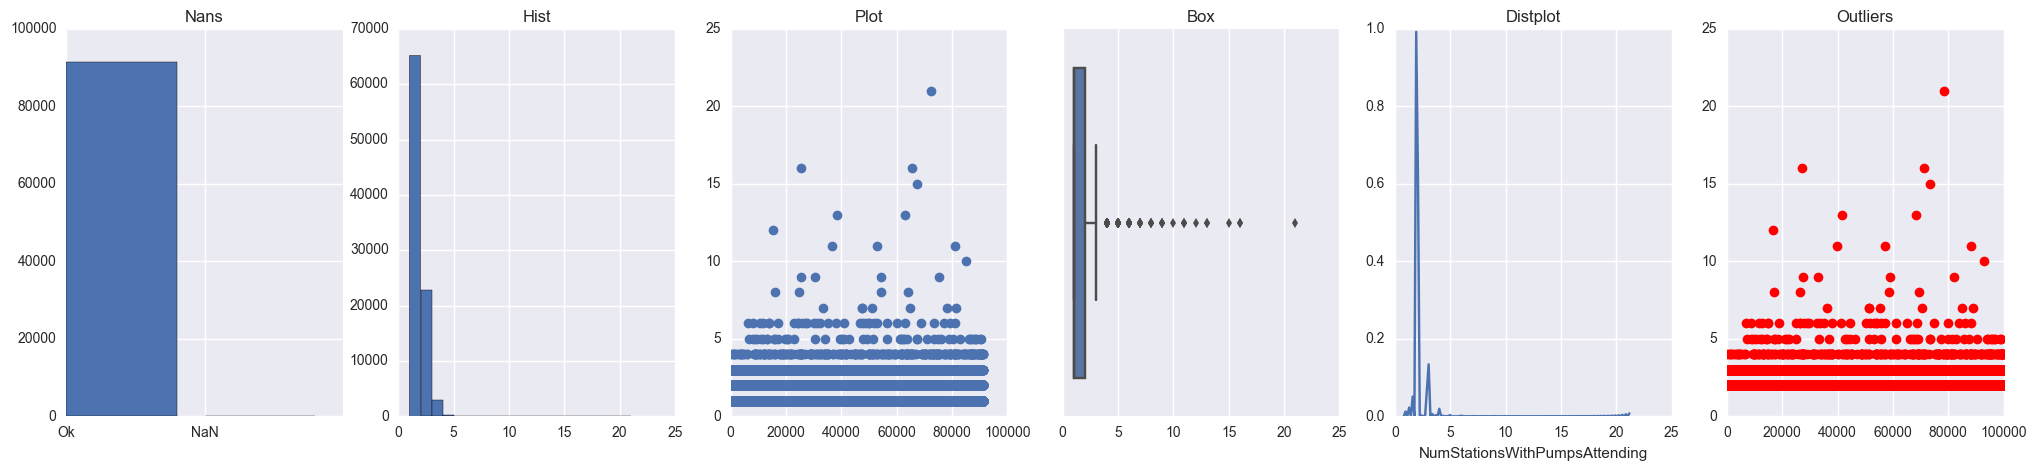

NumPumpsAttending (91318, 22) Ouliers 39329 43.07 % Nans 0 0.00 % 



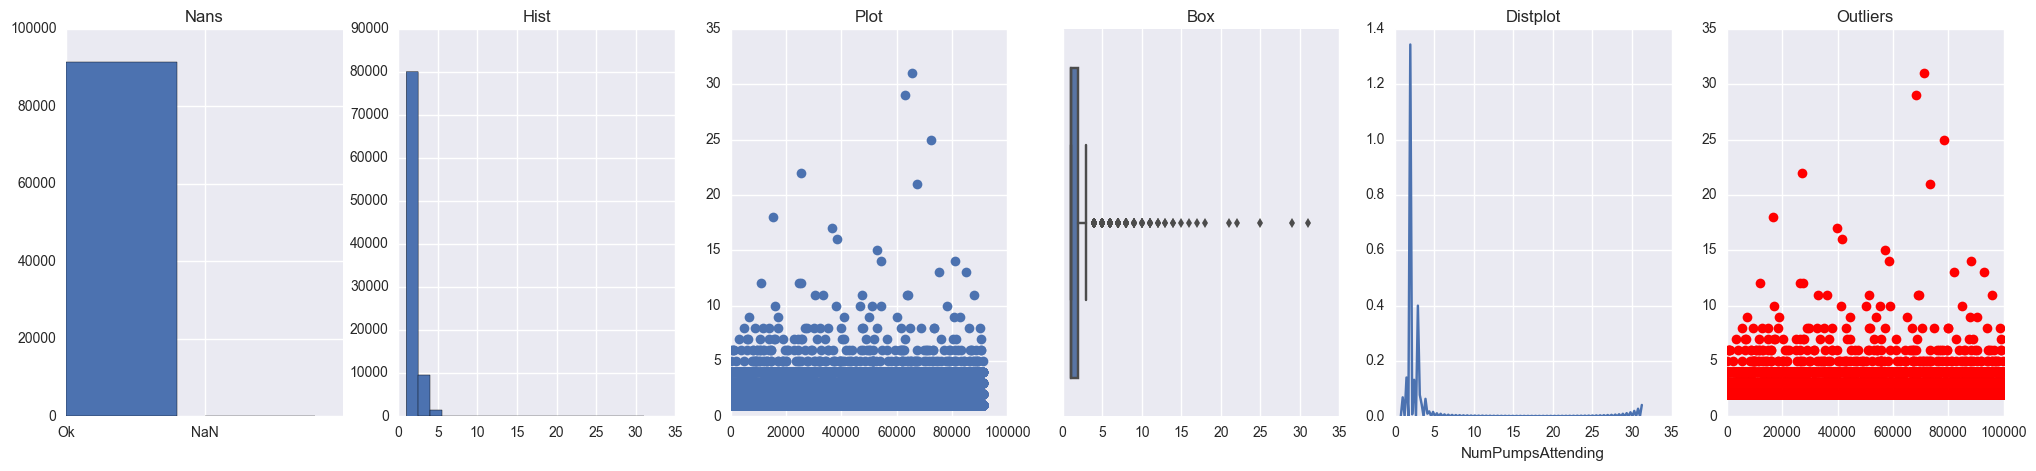

hour (91318, 22) Ouliers 0 0.00 % Nans 0 0.00 % 



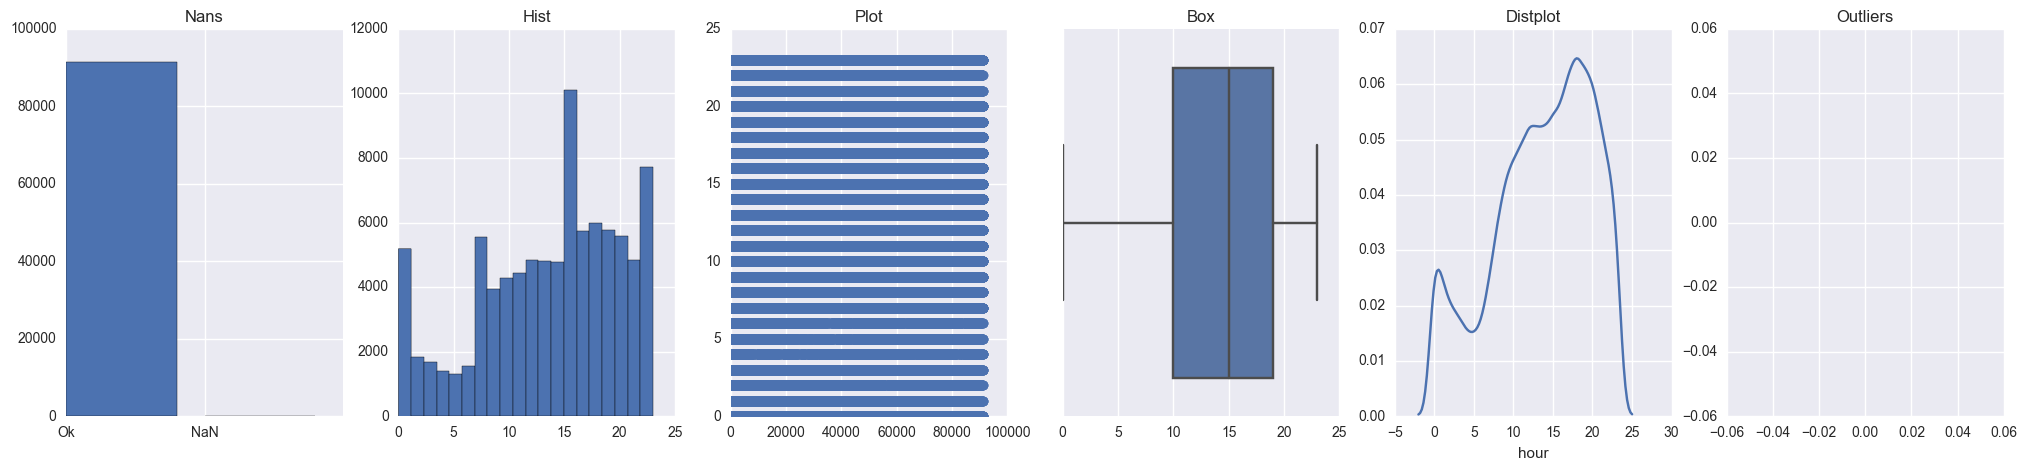

month (91318, 22) Ouliers 0 0.00 % Nans 0 0.00 % 



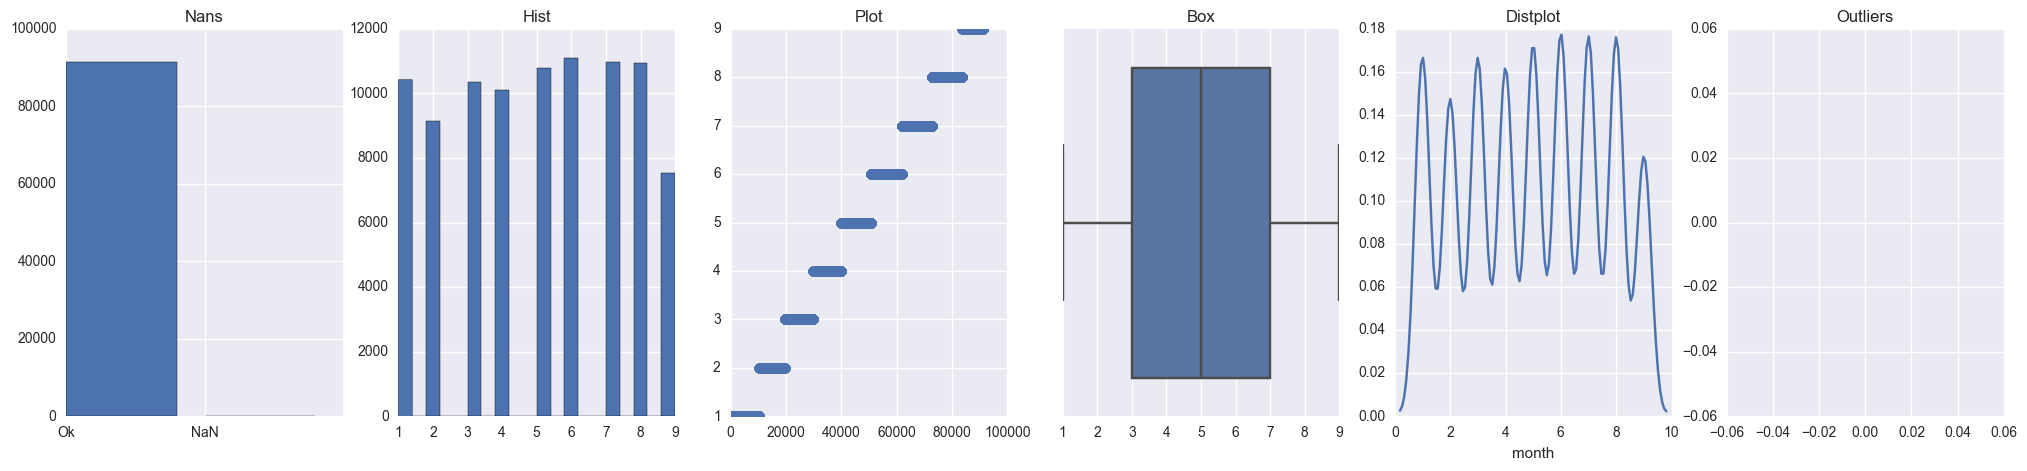

weekday (91318, 22) Ouliers 0 0.00 % Nans 0 0.00 % 



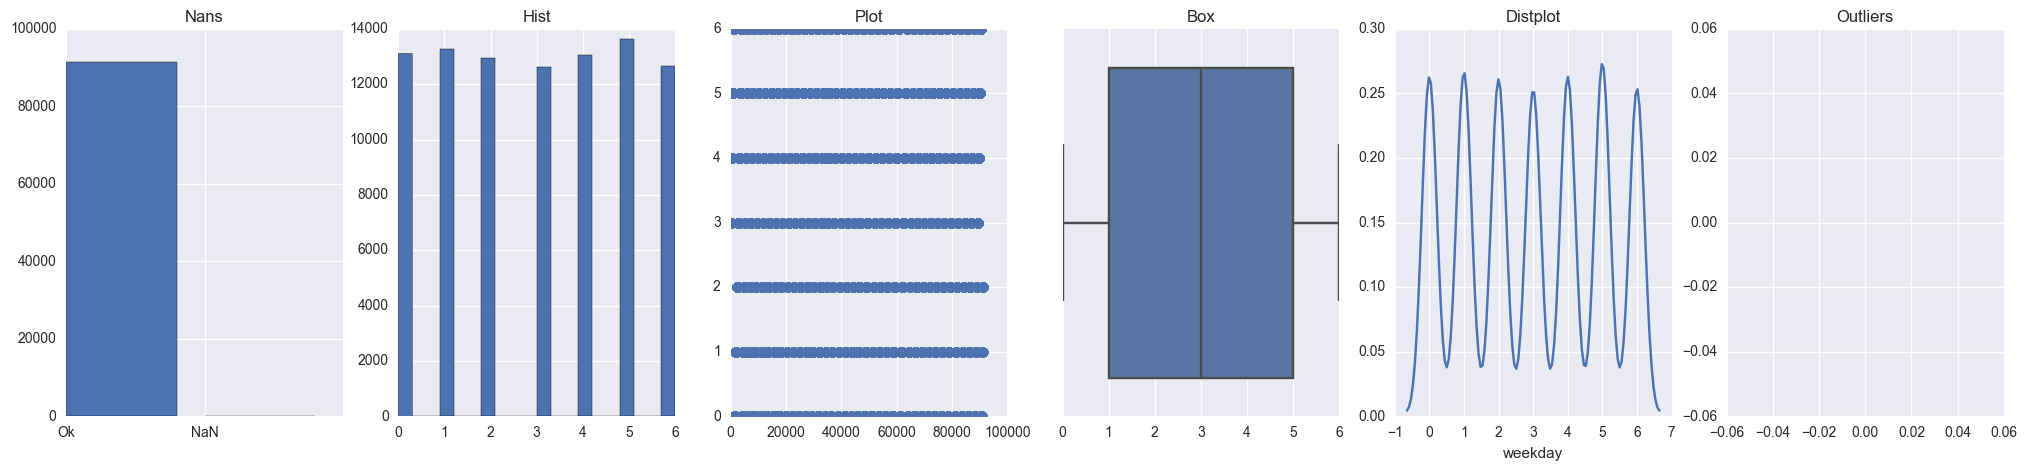

(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)
(91318, 22)


DateOfCall  TimeOfCall  IncidentGroup  StopCodeDescription  \
catcount         266       53521              3                    8   

          PropertyCategory  
catcount                 9

AddressQualifier  Postcode_district  IncGeo_BoroughName  \
catcount                11                 20                  20   

          IncGeo_WardName  IncidentStationGround  
catcount               20                     20

FirstPumpArriving_DeployedFromStation  \
catcount                                     20   

          SecondPumpArriving_DeployedFromStation  DatetimeOfCall  
catcount                                      20           91137

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') IncidentGroup
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
IncidentGroup  counttypes  3 



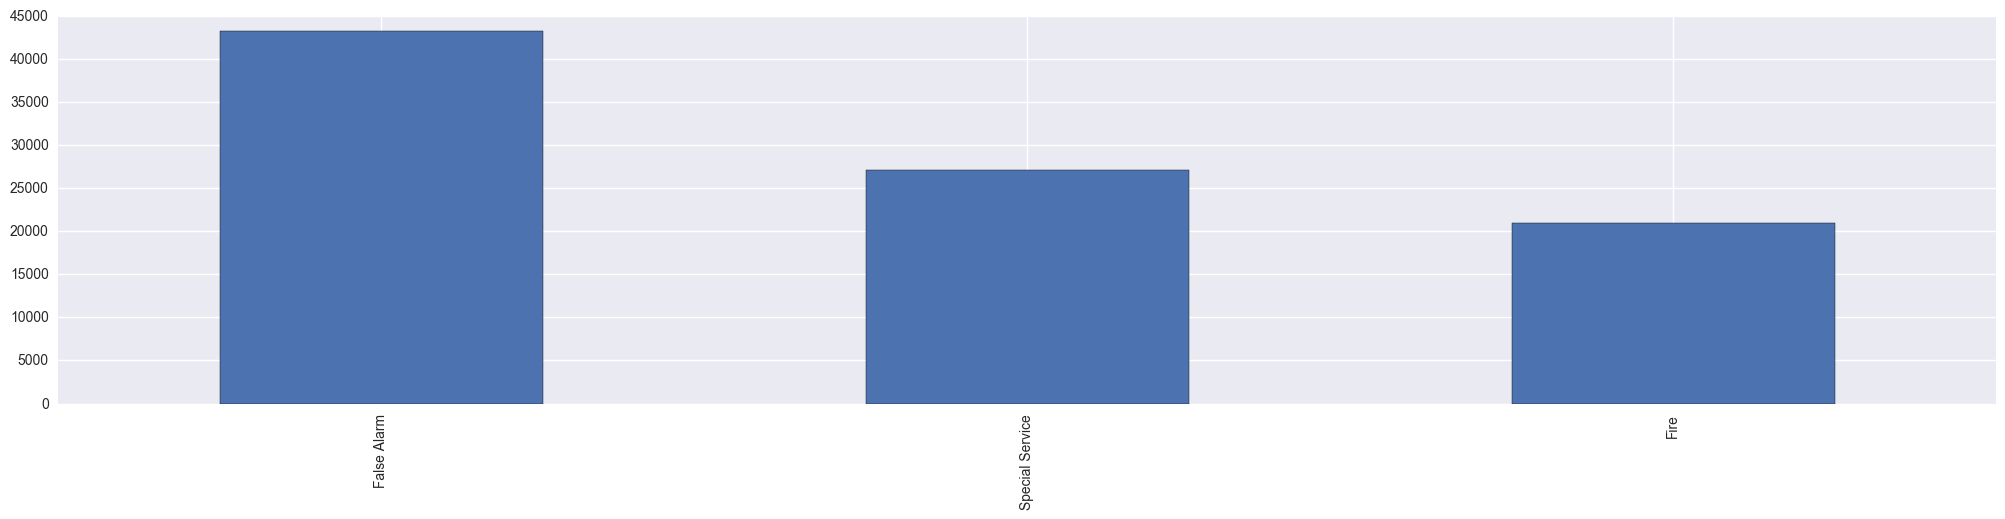

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') StopCodeDescription
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
StopCodeDescription  counttypes  8 



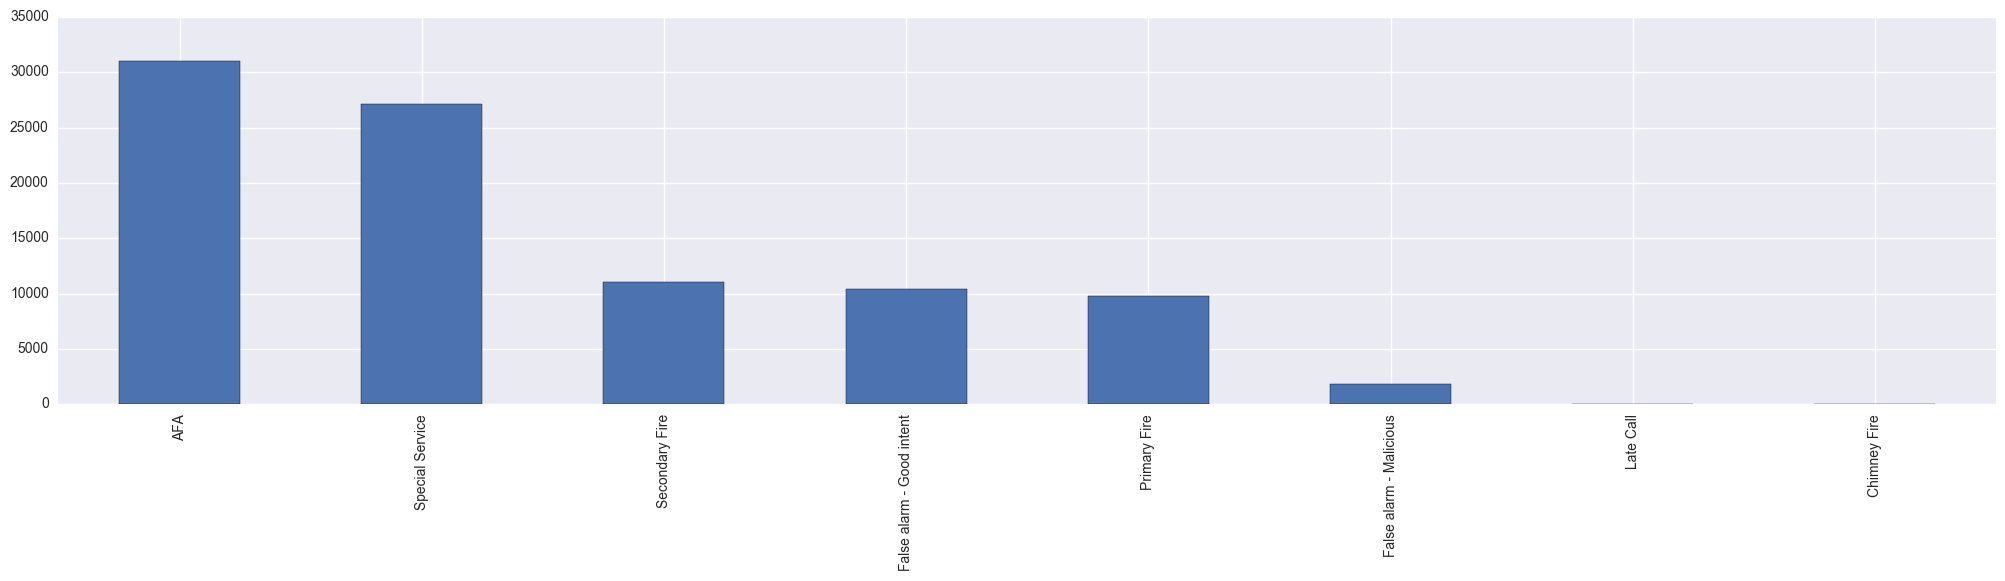

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') PropertyCategory
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
PropertyCategory  counttypes  9 



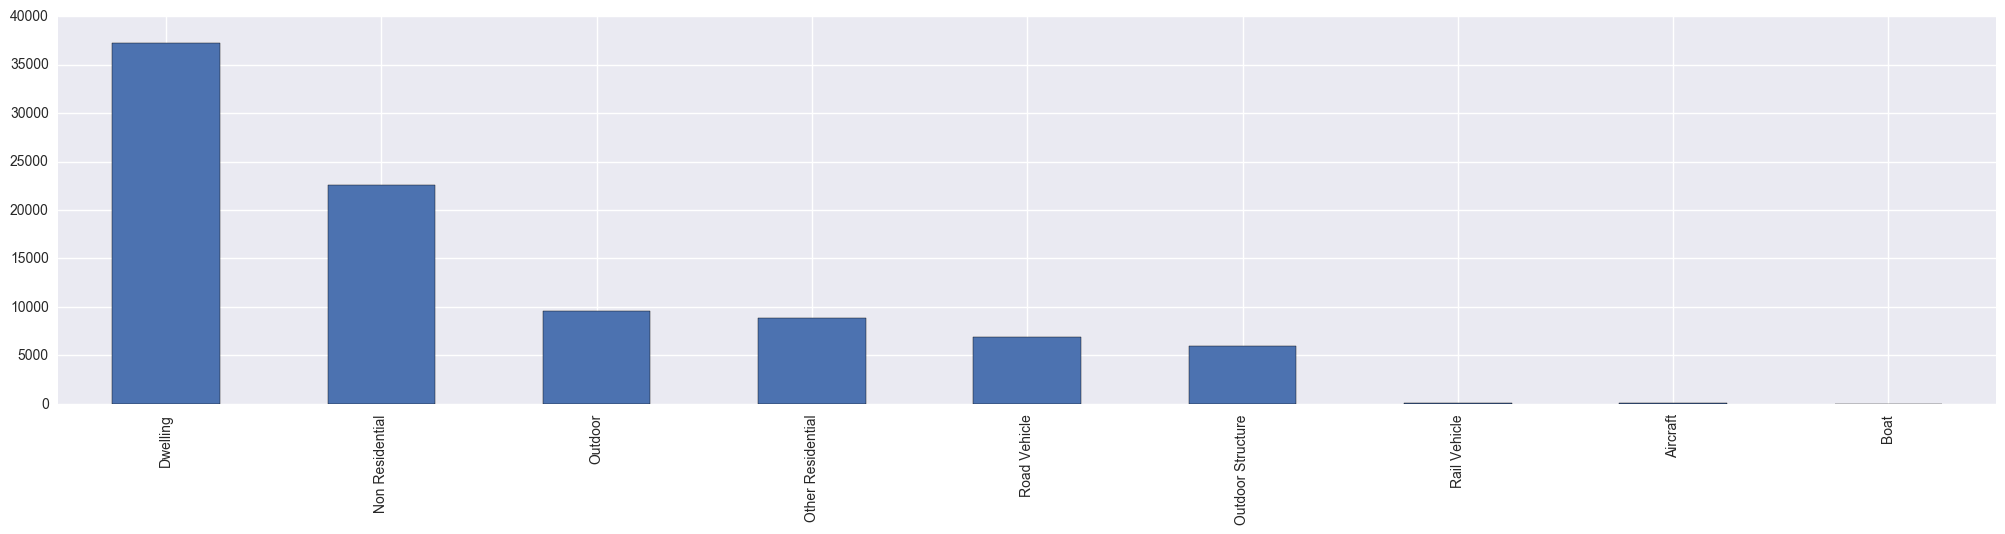

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') AddressQualifier
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
AddressQualifier  counttypes  11 



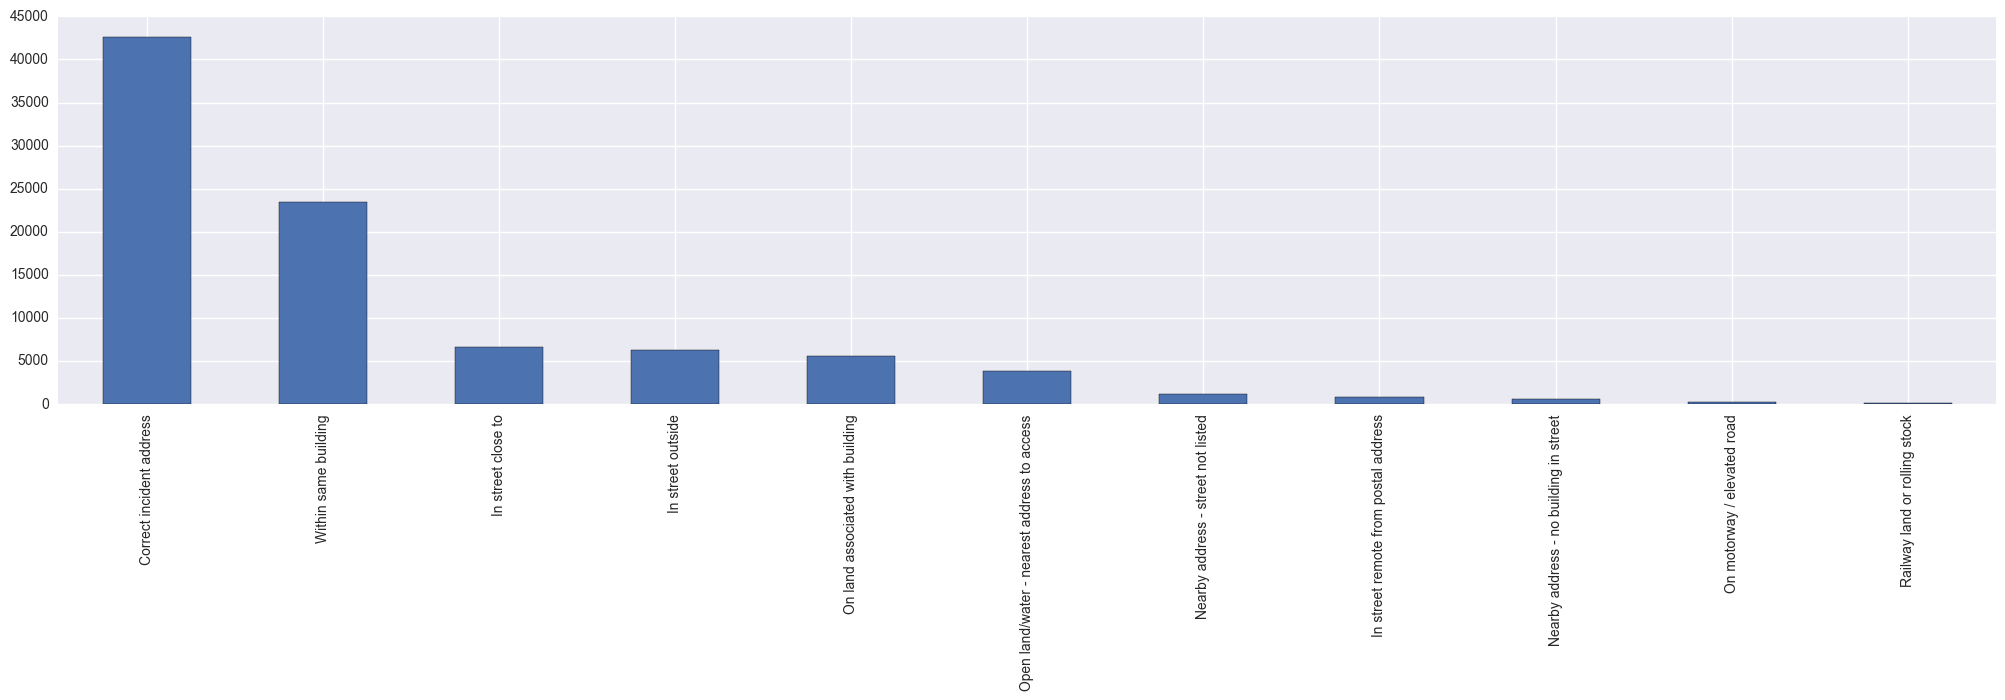

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') Postcode_district
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
Postcode_district  counttypes  20 



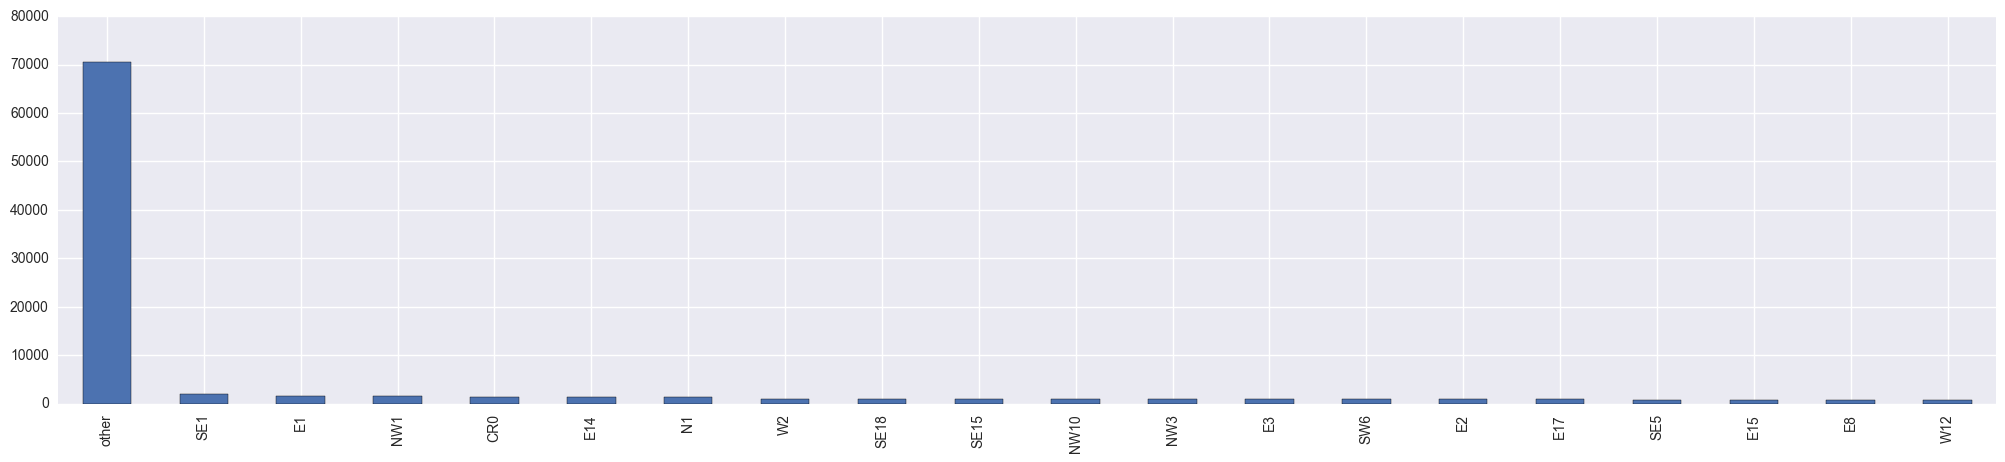

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') IncGeo_BoroughName
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
IncGeo_BoroughName  counttypes  20 



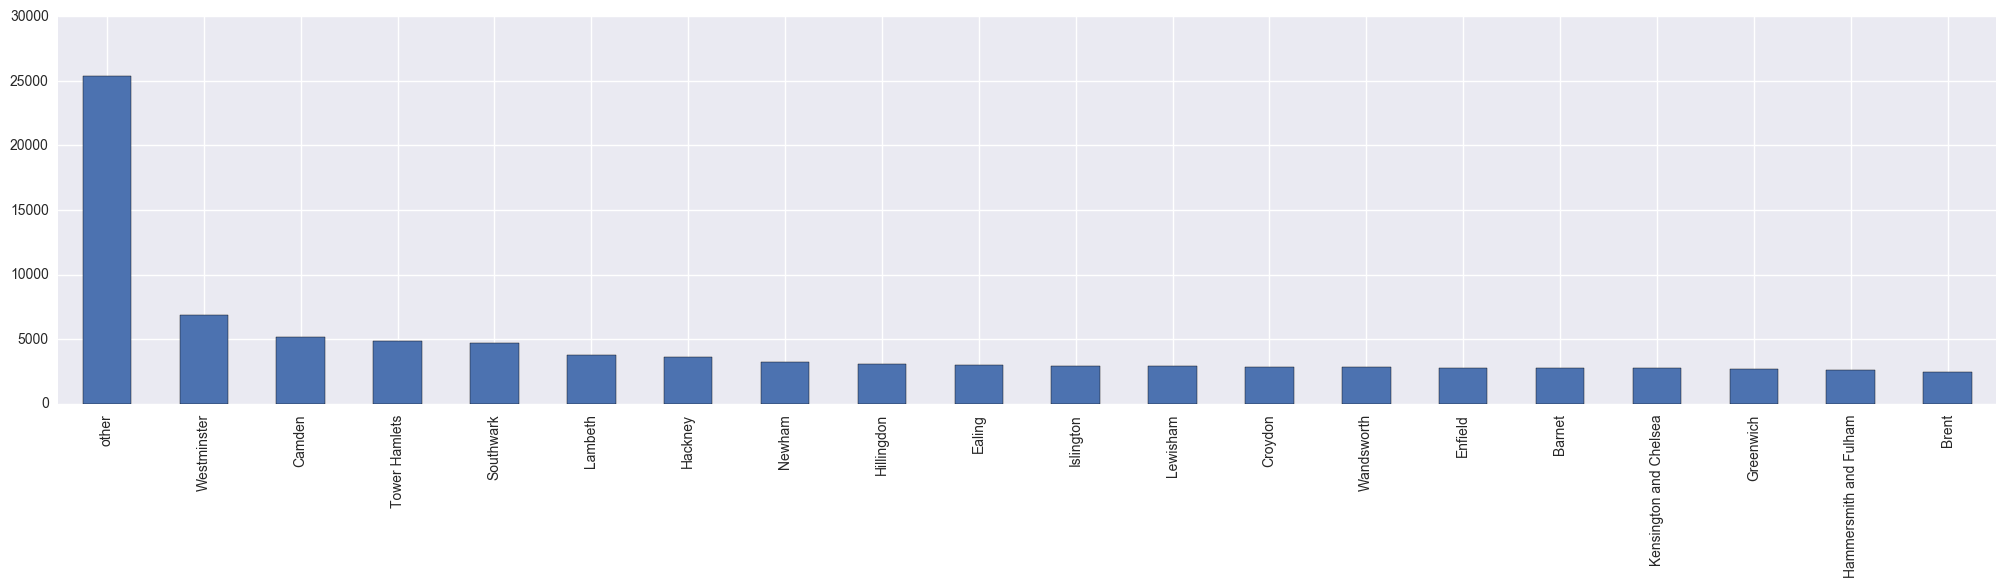

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') IncGeo_WardName
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
IncGeo_WardName  counttypes  20 



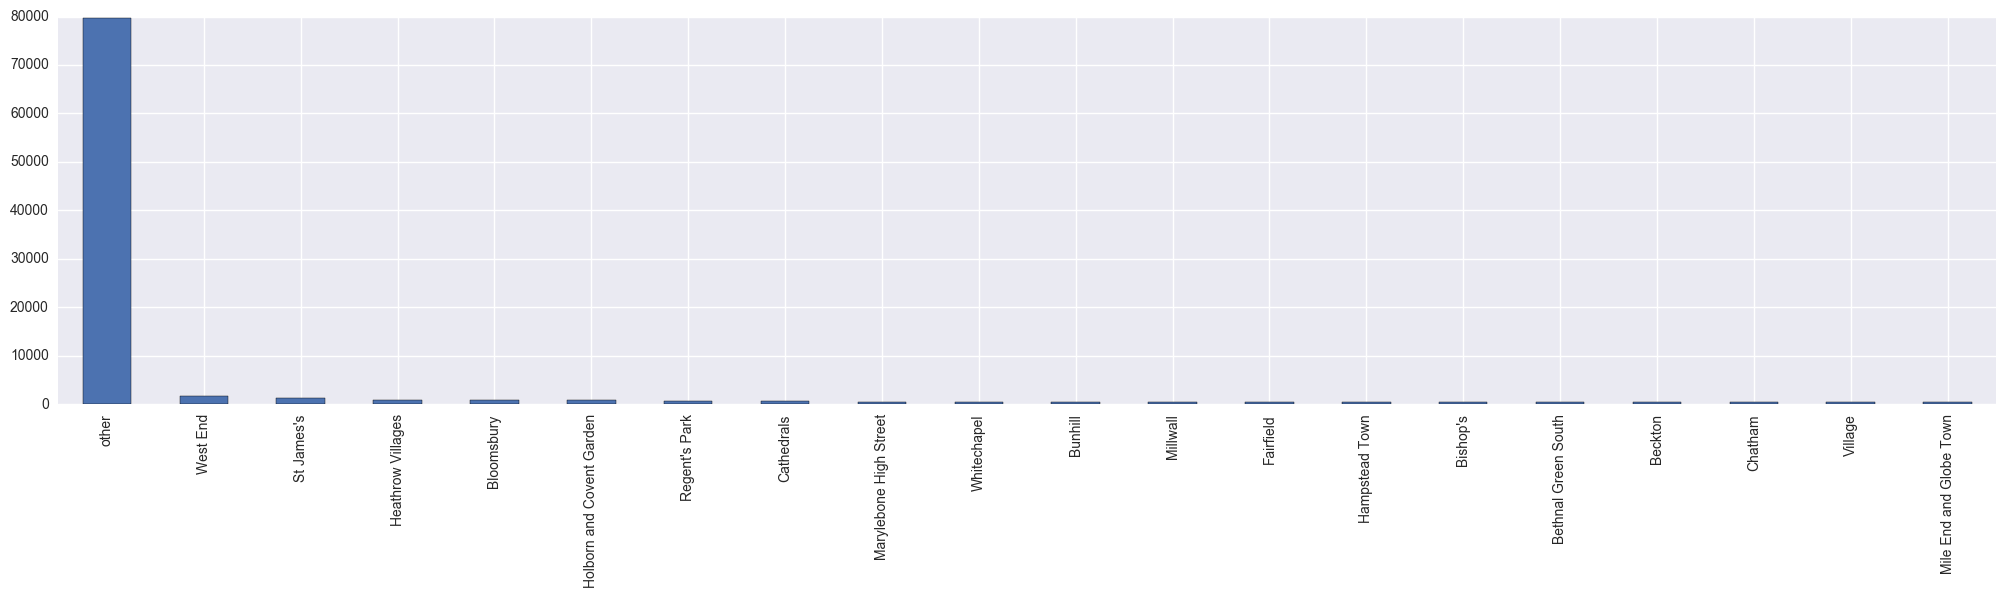

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') IncidentStationGround
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
IncidentStationGround  counttypes  20 



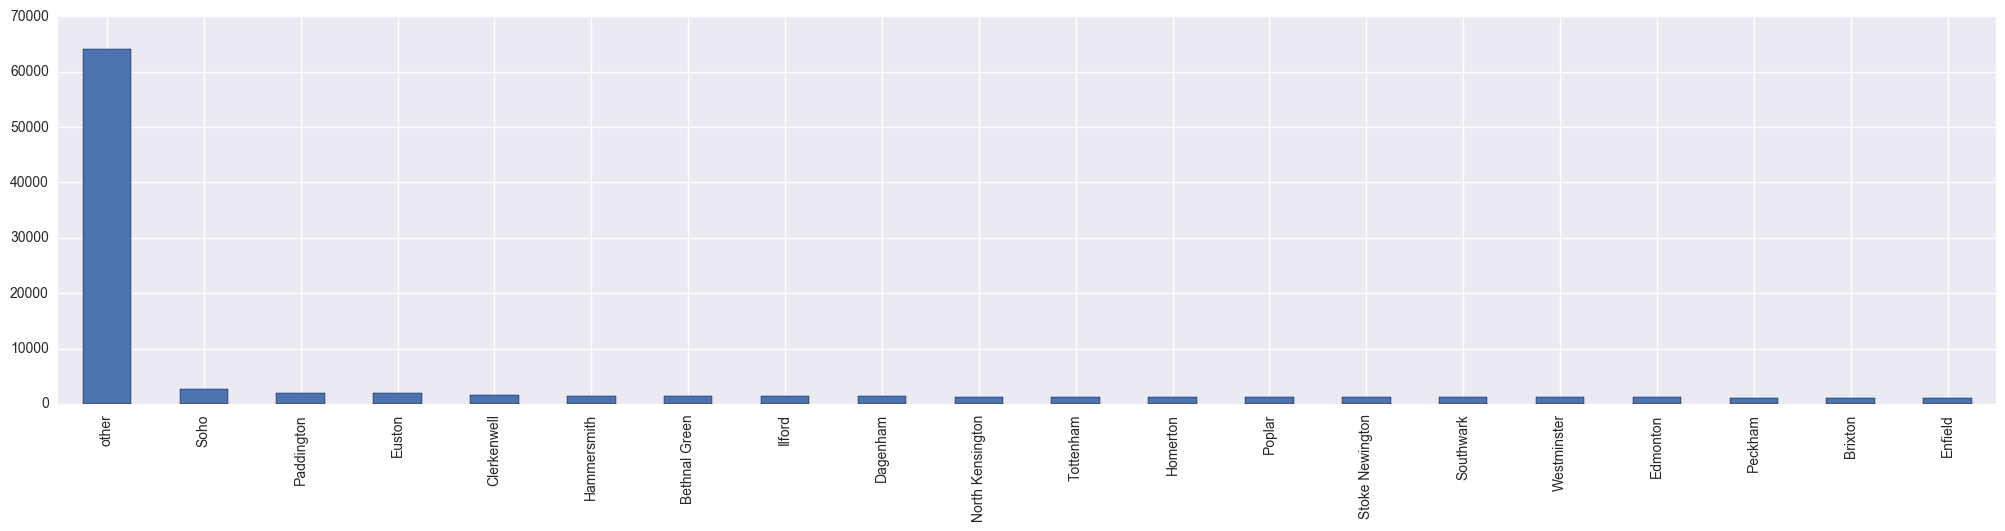

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') FirstPumpArriving_DeployedFromStation
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
FirstPumpArriving_DeployedFromStation  counttypes  20 



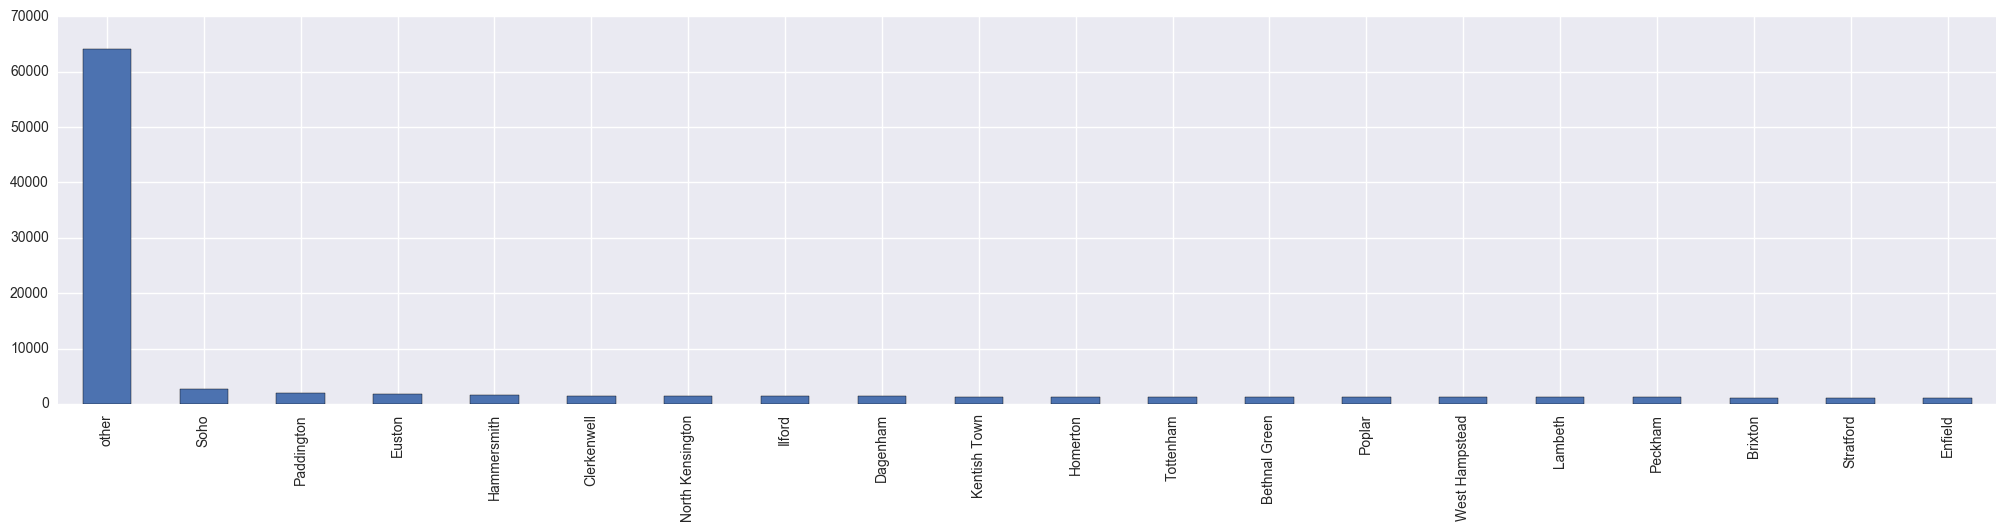

Index(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName',
       'Easting_rounded', 'Northing_rounded', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'DatetimeOfCall',
       'hour', 'month', 'weekday'],
      dtype='object') SecondPumpArriving_DeployedFromStation
(91318, 22) 0 0.00 % elements in bottom  20.00 % of categories
SecondPumpArriving_DeployedFromStation  counttypes  20 



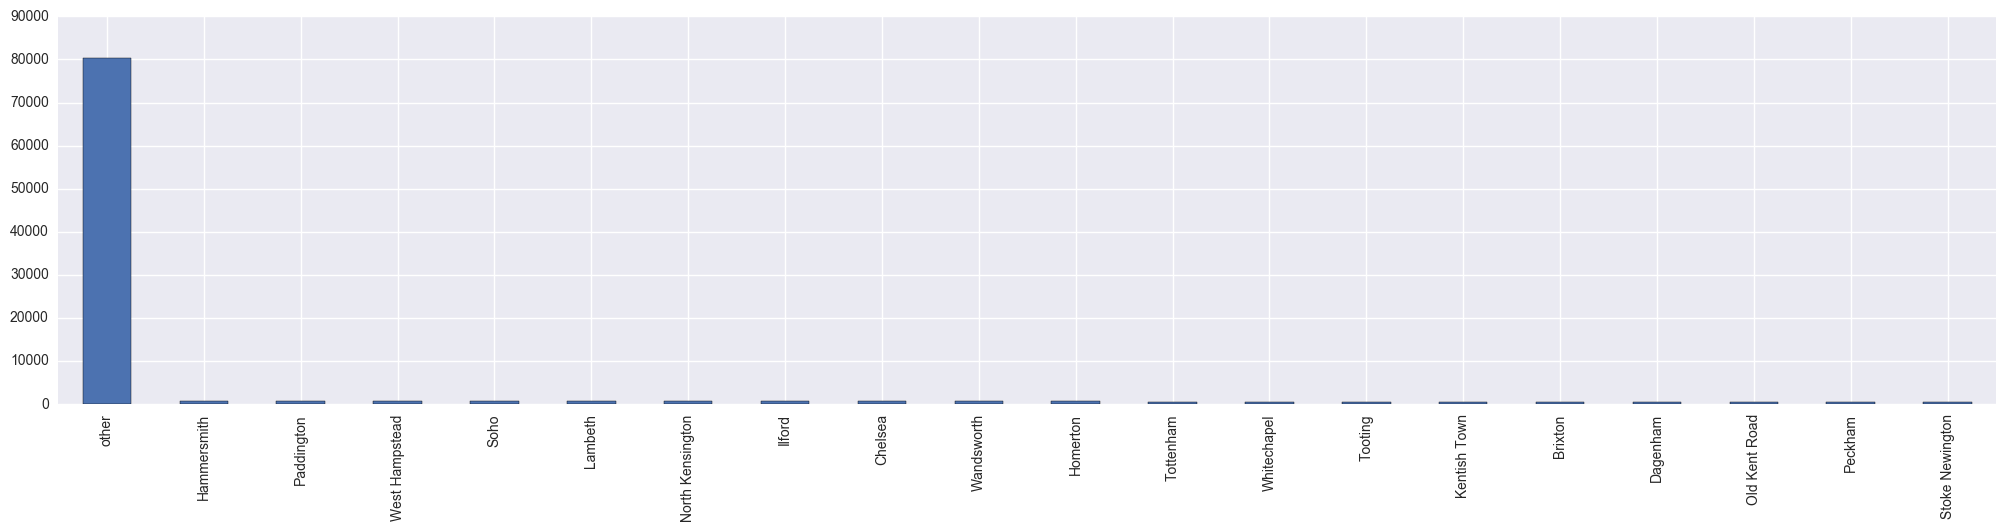

#===============================================
# ONE HOT ENCODING 
#===============================================
['IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'IncGeo_WardCode', 'IncGeo_WardName', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_DeployedFromStation', 'Postcode_full0', 'Postcode_full1']
(91318, 22)


IncidentGroup
0      IncidentGroup_False Alarm
1             IncidentGroup_Fire
2  IncidentGroup_Special Service

StopCodeDescription
0               StopCodeDescription_Chimney Fire
1  StopCodeDescription_False alarm - Good intent
2                  StopCodeDescription_Late Call
3             StopCodeDescription_Secondary Fire
4    StopCodeDescription_False alarm - Malicious
5               StopCodeDescription_Primary Fire
6                        StopCodeDescription_AFA
7            StopCodeDescription_Special Service

PropertyCategory
0  PropertyCategory_Other Residential
1       PropertyCategory_Rail Vehicle
2           PropertyCategory_Aircraft
3  PropertyCategory_Outdoor Structure
4            PropertyCategory_Outdoor
5       PropertyCategory_Road Vehicle
6               PropertyCategory_Boat
7    PropertyCategory_Non Residential
8           PropertyCategory_Dwelling

AddressQualifier
0  AddressQualifier_On land associated with building
1                 AddressQualifier_In street outside
2     AddressQualifier_Railway land or rolling stock
3       AddressQualifier_On motorway / elevated road
4                AddressQualifier_In street close to
5          AddressQualifier_Correct incident address
6  AddressQualifier_Nearby address - no building ...
7              AddressQualifier_Within same building
8  AddressQualifier_In street remote from postal ...
9  AddressQualifier_Nearby address - street not l...

Postcode_district
0    Postcode_district_CR0
1     Postcode_district_E1
2    Postcode_district_E15
3   Postcode_district_SE15
4  Postcode_district_other
5    Postcode_district_E14
6    Postcode_district_SE5
7    Postcode_district_W12
8     Postcode_district_E2
9     Postcode_district_W2

IncGeo_BoroughName
0               IncGeo_BoroughName_Greenwich
1                  IncGeo_BoroughName_Camden
2                 IncGeo_BoroughName_Enfield
3  IncGeo_BoroughName_Kensington and Chelsea
4                   IncGeo_BoroughName_other
5                 IncGeo_BoroughName_Croydon
6             IncGeo_BoroughName_Westminster
7                IncGeo_BoroughName_Lewisham
8                  IncGeo_BoroughName_Newham
9  IncGeo_BoroughName_Hammersmith and Fulham

IncGeo_WardName
0                  IncGeo_WardName_Beckton
1   IncGeo_WardName_Marylebone High Street
2      IncGeo_WardName_Bethnal Green South
3  IncGeo_WardName_Mile End and Globe Town
4                  IncGeo_WardName_Chatham
5                  IncGeo_WardName_Bunhill
6               IncGeo_WardName_St James's
7                  IncGeo_WardName_Village
8               IncGeo_WardName_Bloomsbury
9                 IncGeo_WardName_West End

IncidentStationGround
0          IncidentStationGround_Homerton
1         IncidentStationGround_Tottenham
2              IncidentStationGround_Soho
3             IncidentStationGround_other
4     IncidentStationGround_Bethnal Green
5           IncidentStationGround_Peckham
6       IncidentStationGround_Westminster
7  IncidentStationGround_North Kensington
8       IncidentStationGround_Clerkenwell
9            IncidentStationGround_Ilford

FirstPumpArriving_DeployedFromStation
0  FirstPumpArriving_DeployedFromStation_Clerkenwell
1    FirstPumpArriving_DeployedFromStation_Stratford
2       FirstPumpArriving_DeployedFromStation_Euston
3      FirstPumpArriving_DeployedFromStation_Lambeth
4     FirstPumpArriving_DeployedFromStation_Dagenham
5       FirstPumpArriving_DeployedFromStation_Poplar
6  FirstPumpArriving_DeployedFromStation_Kentish ...
7        FirstPumpArriving_DeployedFromStation_other
8         FirstPumpArriving_DeployedFromStation_Soho
9  FirstPumpArriving_DeployedFromStation_North Ke...

SecondPumpArriving_DeployedFromStation
0       SecondPumpArriving_DeployedFromStation_other
1        SecondPumpArriving_DeployedFromStation_Soho
2   SecondPumpArriving_DeployedFromStation_Tottenham
3     SecondPumpArriving_DeployedFromStation_Peckham
4  SecondPumpArriving_DeployedFromStation_Whitech...
5  SecondPumpArriving_DeployedFromStation_Kentish...
6     SecondPumpArriving_DeployedFromStation_Brixton
7     SecondPumpArriving_DeployedFromStation_Chelsea
8  SecondPumpArriving_DeployedFromStation_North K...
9    SecondPumpArriving_DeployedFromStation_Dagenham

#===============================================
# COMPLETE DATA CLEAN FOR df 
#===============================================


In [18]:
df_temp = df
print("Numerical columns")
print (numcols)
print("Categorical columns")
print (catcols)
outcols = ['IncidentNumber', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', 'FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime']
remcols = ['Easting_m','Northing_m', 'SecondPumpArriving_AttendanceTime', 'SpecialServiceType','PropertyType','Postcode_full', 
           'IncGeo_BoroughCode', 'IncGeo_WardCode', 'Postcode_full0', 'Postcode_full1', 'FRS']
nancols =  ["FirstPumpArriving_AttendanceTime","NumStationsWithPumpsAttending","NumPumpsAttending"]
logcols = ["FirstPumpArriving_AttendanceTime", "SecondPumpArriving_AttendanceTime"]
filtcols = ["Postcode_district", "IncGeo_BoroughName", "IncGeo_WardName", "IncidentStationGround", "FirstPumpArriving_DeployedFromStation", "SecondPumpArriving_DeployedFromStation"]

if(False):
    outcols = []
    remcols = []
    nancols =  []
    logcols = []

# After examination of dataset
#===============================================
# 1) Remove certain value, Nans 
#===============================================
df_temp = removenansfromcols(df_temp,nancols)
#===============================================
# 2) make cols normal through ln
#===============================================
df_temp = makenormalfromlog(df_temp, logcols)
#===============================================
# 3) Remove outliers on cols
#===============================================
df_temp = removeoutliersfromcols(df_temp, outcols)
#===============================================
# 4) Remove cols that don't matter
#===============================================
df_temp = removecols(df_temp, remcols)
#===============================================
# 5) Filter cols with large cat number
#===============================================
df_temp = filteronsig(df_temp,filtcols, num=20)
 
#===============================================
# Examine the dataset
#===============================================
ignorecols = []
#ignorecols = ['IncidentNumber', 'Easting_m','Northing_m','Easting_rounded','Northing_rounded']
len(numcols)
stats = dataframestats(df_temp)
ut.dispdf(stats, 5, num=20)

#Skip/Include examine of numericals
if(True):
    for c in numcols:
        if(c not in ignorecols and c in df_temp.columns):
            examineonenumcol(df_temp, c)
        
threshold = 0.8
print(df_temp.shape)
cstats = dataframecatstats(df_temp)
ut.dispdf(cstats, 5, num=20)
if(True):
    for c in catcols:
        if(c not in ignorecols and c in df_temp.columns):
            examineonecatcol(df_temp, c, threshold)

#===============================================
# 6) ASSIGN it back to df - when you are happy with it!!!!!
#===============================================
if(True):
    print("#===============================================")
    print("# ONE HOT ENCODING ")
    print("#===============================================")
    #do the one hot encoding
    print(catcols)
    print(df_temp.shape)
    df_temp = encodecols(df_temp, catcols)

    df_orig = df
    df = df_temp
    df = df.reset_index(drop=True)
    numcols, datcols, catcols = splitcoltypes(df)
    print("#===============================================")
    print("# COMPLETE DATA CLEAN FOR df ")
    print("#===============================================")

#print("#===============================================")
#print("# AFTER TRANSFORM")
#print("#===============================================")


## 5) deal with categorical
- 5a) for each col count values
- 5b) fill in missing values/drop them

## 6) nlp -> look but dont touch

## 6) Finally remove the columns that dont' matter to get final dataset we can work on clealy

## 7) Nice clean data set we can do something to

## 7a) do a big old linear regression map and them iso map it

In [19]:
def plot_matrix(cm, classesx, classesy,
                          normalize=True,
                          title='matrix',
                          cmap=plt.cm.Blues,
                          axis=0):
   
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marksx = np.arange(len(classesx))
    plt.xticks(tick_marksx, classesx, rotation=90)
    tick_marksy = np.arange(len(classesy))
    plt.yticks(tick_marksy, classesy)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.grid(False) 
    #for axi in (ax.xaxis, ax.yaxis):
    #    for tic in axi.get_major_ticks():
    #        tic.tick1On = tic.tick2On = True
    #        tic.label1On = tic.label2On = False
    orig = cm
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=axis)
    thresh = (cm.max() - cm.min()) * 0.5 + cm.min()
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        s = "{:1.2f}".format(cm[i,j])
        #s = "{:1.4f}".format(cm[i,j]) + "("+str(orig[i,j])+")"
        plt.text(j, i, s, horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('Y label')
    plt.xlabel('X label')

def onelr(x1, y1):
    lr = LinearRegression()
    lr.fit(x1, y1)
    
    return lr.score(x1, y1)

def plotcorrel(df_temp, colsx, colsy):
    num_coef = np.empty((len(colsx),len(colsy),))
    num_coef[:] = np.NAN
    x_labels = []
    y_labels = []
    for i in range(len(colsx)):
        c_i = colsx[i]
        if(c_i in df_temp.columns):
            df_temp = df_temp.dropna(subset=[c_i])
            y_labels.append(c_i + "("+str(df_temp.shape[0])+")")
            #print(c_i, df_temp.shape)
            for j in range(len(colsy)):
                c_j = colsy[j]
                if len(x_labels)  < len(colsy):
                     x_labels.append(c_j + "("+str(df_temp.shape[0])+")")
                if(c_j in df_temp.columns):
                    df_temp = df_temp.dropna(subset=[c_j])
                    vals_i = df_temp[c_i].values.reshape(-1,1)
                    vals_j = df_temp[c_j].values.reshape(-1,1)
                    if(np.isnan(vals_j).sum() == 0):
                        #r = onelr(vals_i, vals_j)
                        pcor = sp.stats.pearsonr(vals_i, vals_j)
                        #print(pcor)
                        num_coef[i, j] = pcor[0][0]
    #print(num_coef)
    ut.figurefullwidth()
    plot_matrix(num_coef, x_labels, y_labels, normalize=False, title="")

['NumPumpsAttending', 'IncidentNumber', 'Easting_rounded', 'NumStationsWithPumpsAttending', 'FirstPumpArriving_AttendanceTime', 'weekday', 'hour', 'month', 'Northing_rounded']


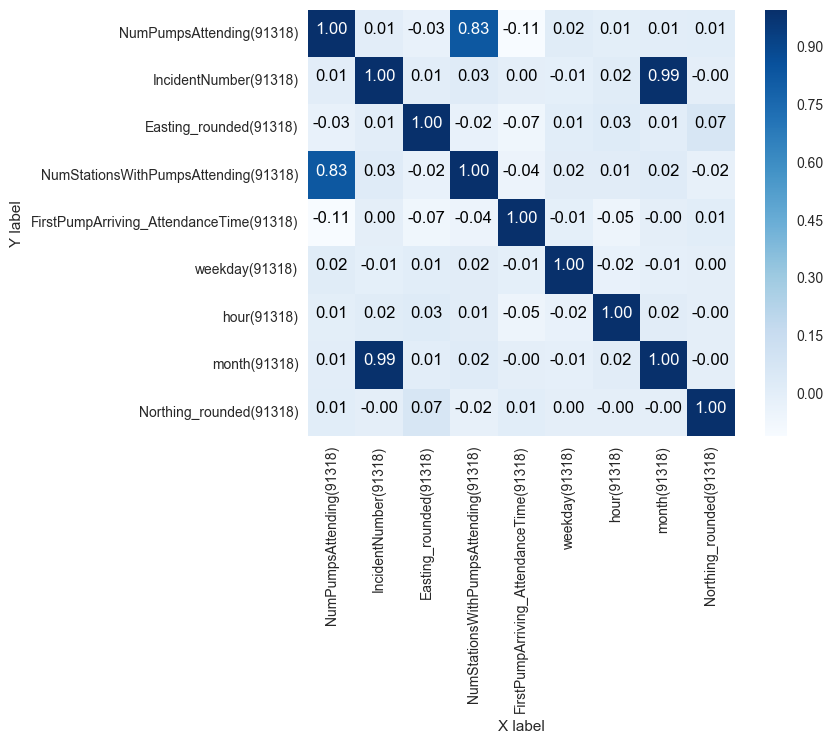

In [20]:
numcolsexOH = numcols
for key in onehotencodings.keys():
    numcolsexOH = list(set(numcolsexOH) - set(onehotencodings[key]))
print(numcolsexOH)
plotcorrel(df, numcolsexOH, numcolsexOH)
plt.figure()
#plt.plot(df["NumStationsWithPumpsAttending"], df["NumPumpsAttending"], 'o')
#plt.show()

10

['IncidentGroup', 'StopCodeDescription', 'PropertyCategory', 'AddressQualifier', 'Postcode_district', 'IncGeo_BoroughName', 'IncGeo_WardName', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_DeployedFromStation']
IncidentGroup IncidentGroup


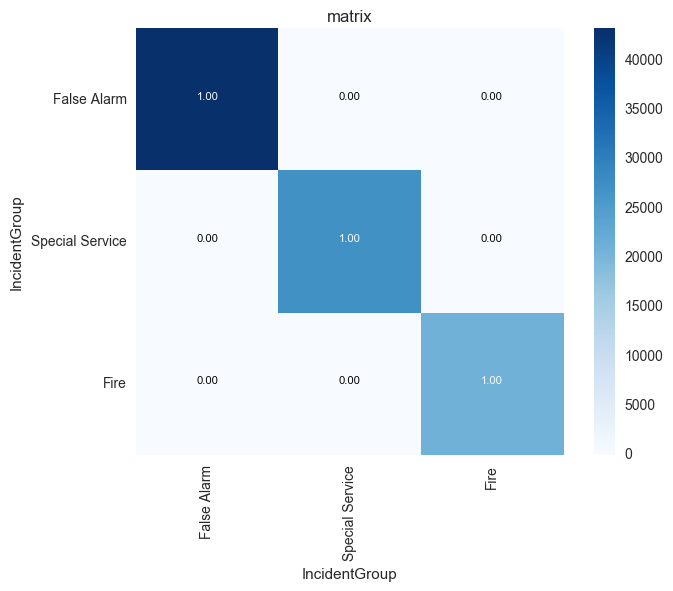

IncidentGroup StopCodeDescription


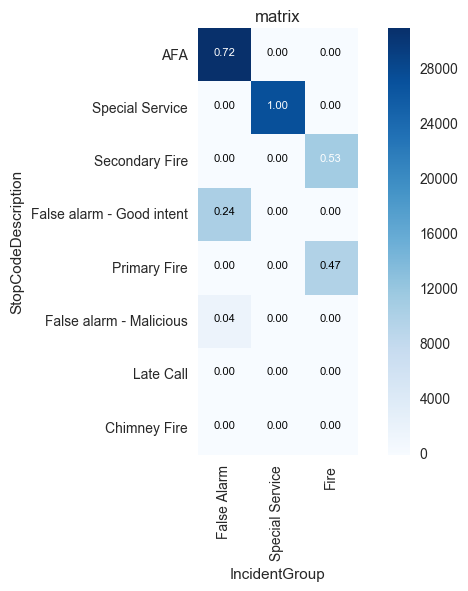

IncidentGroup PropertyCategory


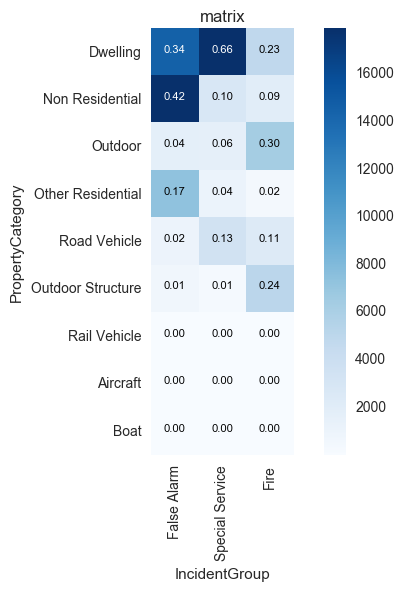

IncidentGroup AddressQualifier


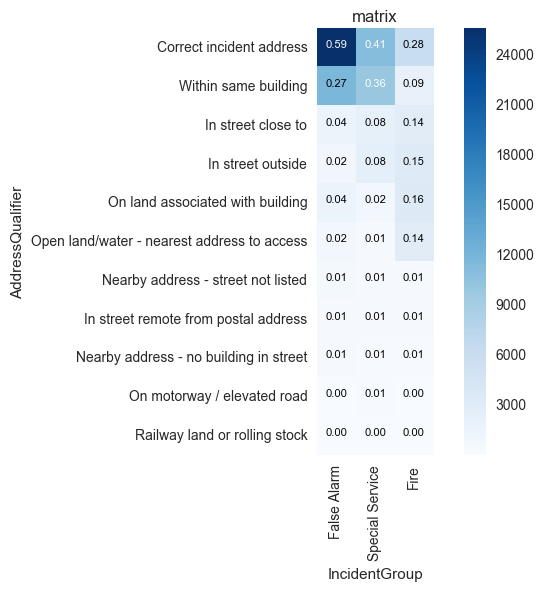

IncidentGroup Postcode_district


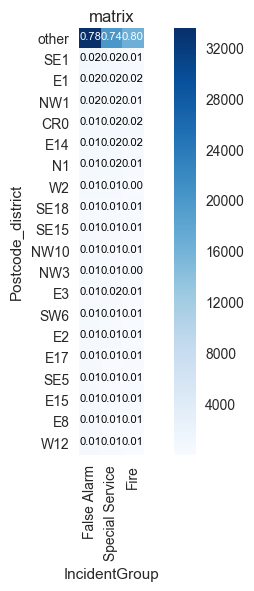

IncidentGroup IncGeo_BoroughName


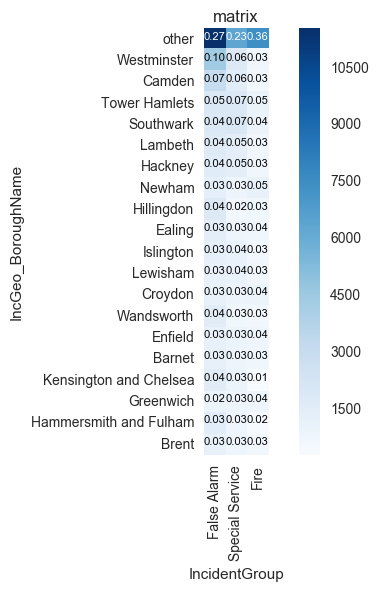

IncidentGroup IncGeo_WardName


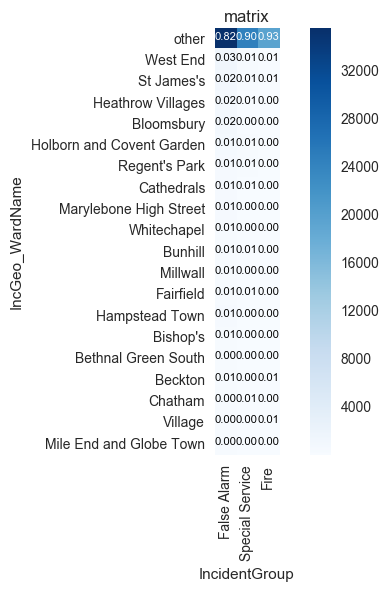

IncidentGroup IncidentStationGround


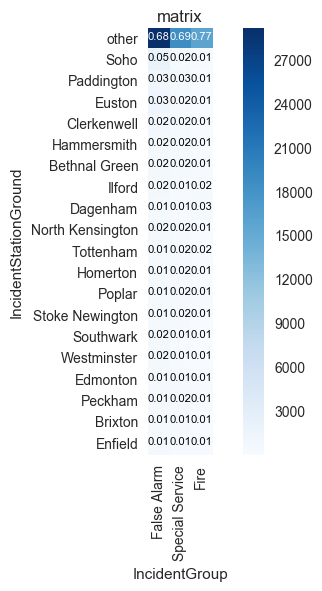

IncidentGroup FirstPumpArriving_DeployedFromStation


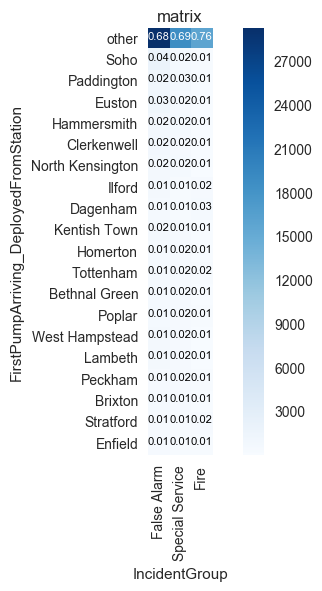

IncidentGroup SecondPumpArriving_DeployedFromStation


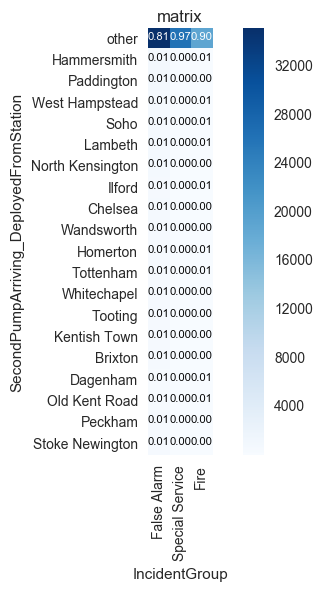

In [21]:
 
def plot_catmatrix(cm, x_labels, y_labels,
                          normalize=False,
                          title='matrix',
                          cmap=plt.cm.Blues,
                          y_title="", x_title="",
                          axis=0):
   
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(x_labels))
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation=90)
    plt.yticks(np.arange(len(y_labels)), y_labels)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.grid(False) 
    #for axi in (ax.xaxis, ax.yaxis):
    #    for tic in axi.get_major_ticks():
    #        tic.tick1On = tic.tick2On = True
    #        tic.label1On = tic.label2On = False
    orig = cm
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=axis)
    thresh = (cm.max() - cm.min()) * 0.5 + cm.min()
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        v = cm[i,j]
        if(np.isnan(v)):
            s = '-'
        else:
            s = "{:1.2f}".format(v)
        #s = "{:1.4f}".format(cm[i,j]) + "("+str(orig[i,j])+")"
        plt.text(j, i, s, horizontalalignment="center",fontsize=8,
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.show()

def vc(df, c1, num=30):
    vc1 = df[c1].value_counts()
    n1 = vc1.index.tolist()
    
    if(len(n1) > num):
        df_temp = filteronsig(df, [c1], num=num)
        vc1 = df_temp[c1].value_counts()
        n1 = vc1.index.tolist()
    return vc1, n1


            
def plotcols(df, c1, c2):
    print(c1, c2)
    if(c1 in df.columns):
        vc1, n1 = vc(df, c1)
    else:
        return
    if(c2 in df.columns):
        vc2, n2 = vc(df, c2)
    else:
        return
    
    counts = np.empty((len(n1),len(n2),))
    counts[:] = np.NAN
    #print(vc2)
    for i in range(len(n1)):
        for j in range(len(n2)):
            if(c1 in df.columns and c2 in df.columns):
                c = len(df[(df[c1]==n1[i]) & (df[c2]==n2[j])])
                #print(c)
                counts[i,j] = c
    #print(counts)
    plot_catmatrix(np.transpose(counts), n1, n2, normalize=True, y_title=c2, x_title=c1)
    #x = LabelEncoder().fit_transform(df[c1])
    #y = LabelEncoder().fit_transform(df[c2])
    #plt.plot(x, y, 'o')
    #plt.show()
len(catcols)
#print(df.head())
print(catcols)
for c in catcols:
    plotcols(df, catcols[0], c)
#plotcols(df, catcols[0], catcols[4])


IncidentGroup


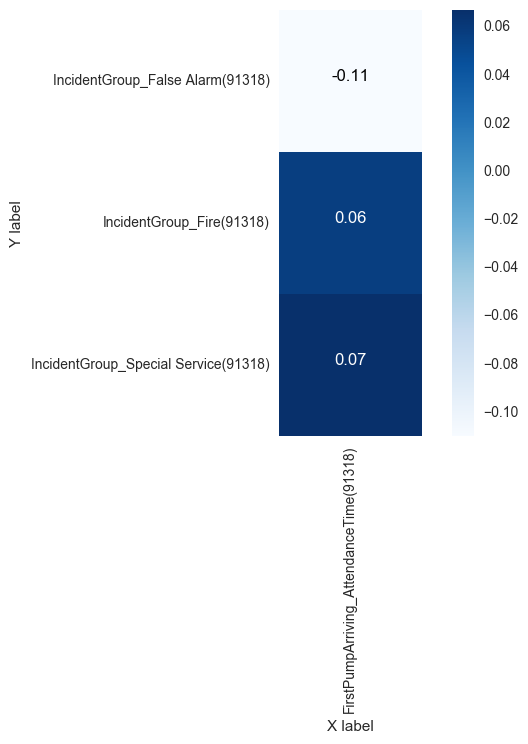

StopCodeDescription


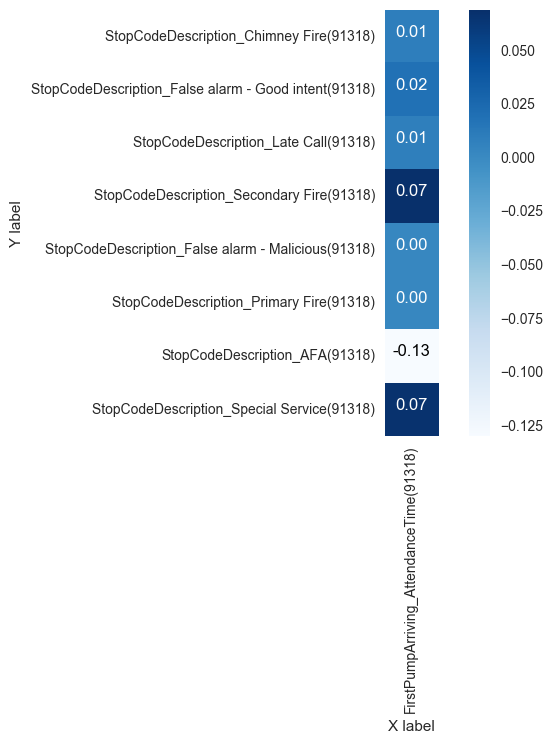

PropertyCategory


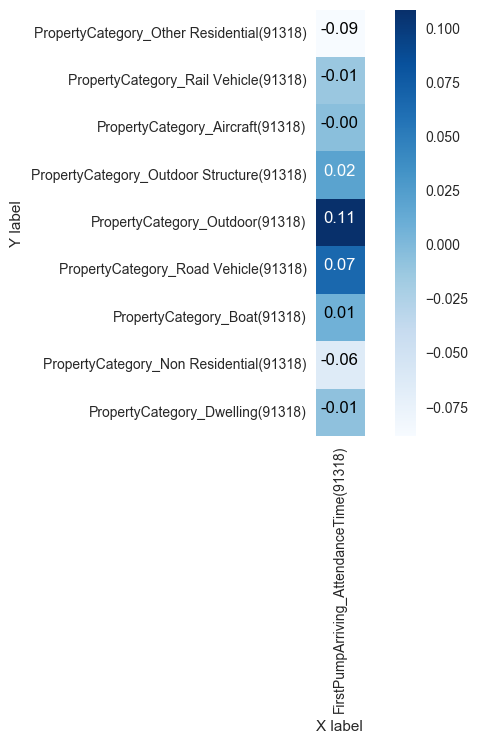

AddressQualifier


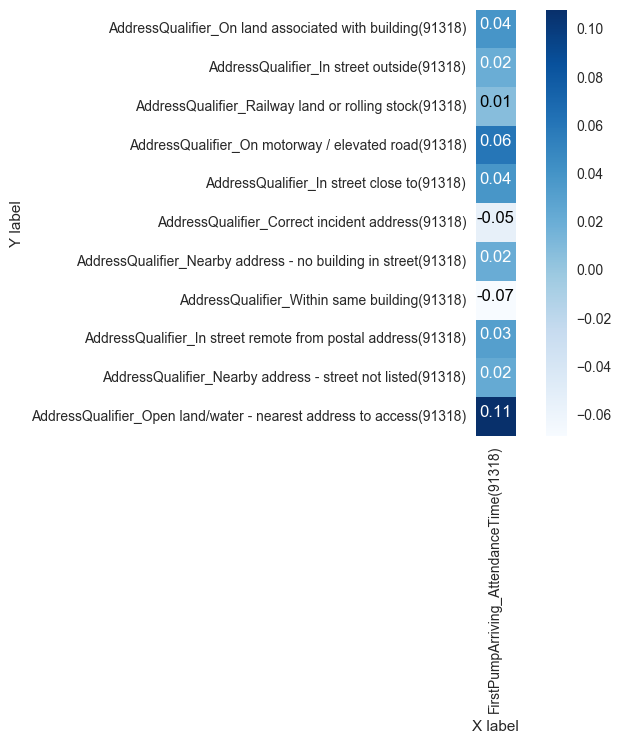

Postcode_district


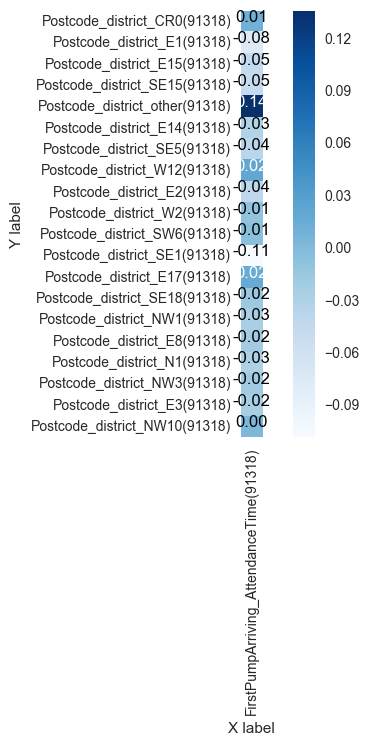

IncGeo_BoroughName


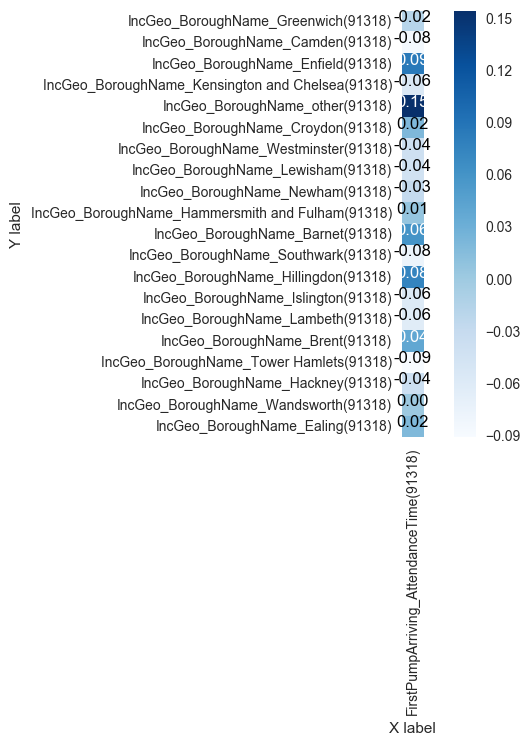

IncGeo_WardName


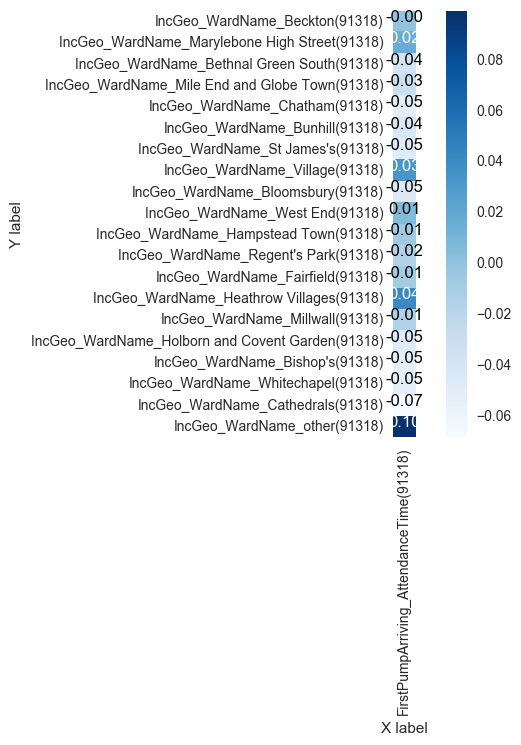

IncidentStationGround


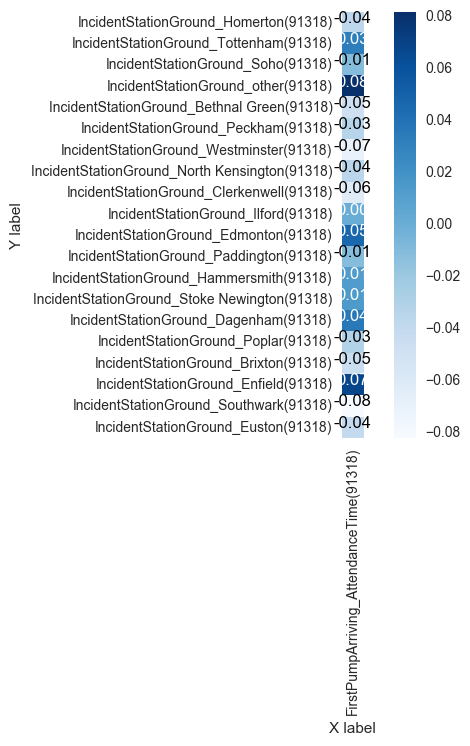

FirstPumpArriving_DeployedFromStation


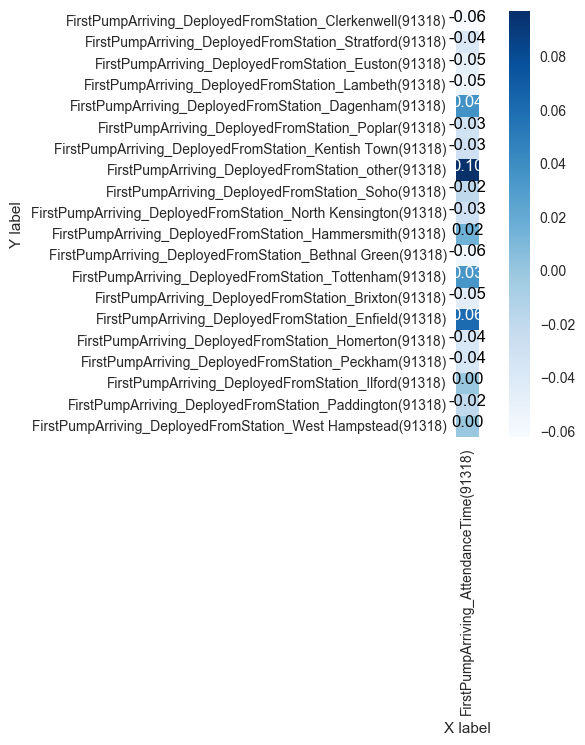

SecondPumpArriving_DeployedFromStation


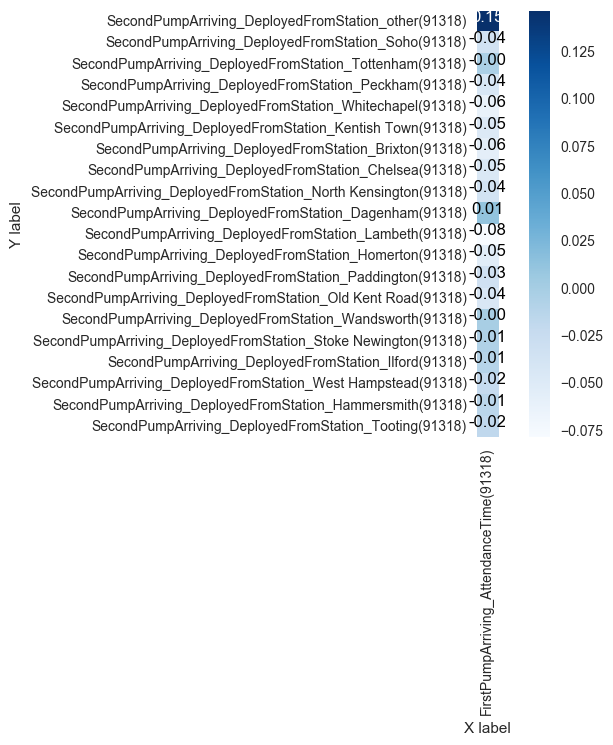

In [22]:


for i in catcols:
    ohlist = onehotencodings[i]
    print(i)
    #print(ohlist)
    #print(df_temp.shape)
    ut.figurefullwidth()
    plotcorrel(df_temp, ohlist, ["FirstPumpArriving_AttendanceTime"])
    plt.show()



#print(df2.head())

## Plot categories vs 1 numberical

FirstPumpArriving_AttendanceTime IncidentGroup
ANOVA 556.124081904 8.65869013538e-241
['False Alarm' 'Fire' 'Special Service']
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1        group2     meandiff lower  upper  reject
---------------------------------------------------------
False Alarm       Fire       0.0863  0.0786 0.094   True 
False Alarm Special Service  0.0856  0.0786 0.0927  True 
    Fire    Special Service -0.0006  -0.009 0.0077 False 
---------------------------------------------------------


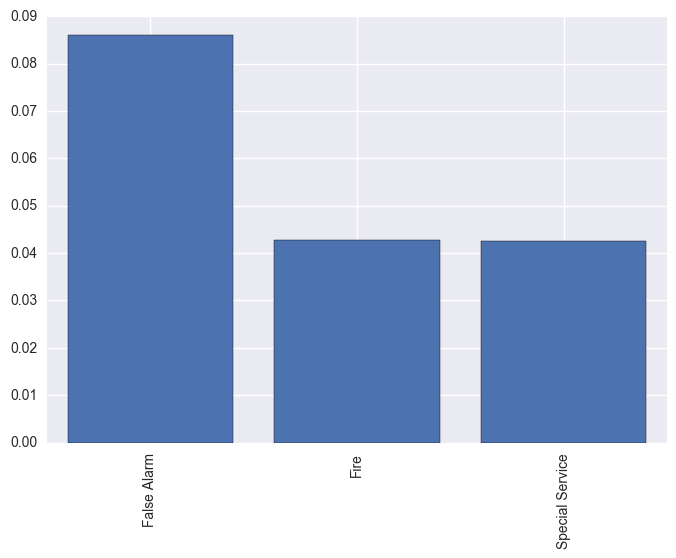

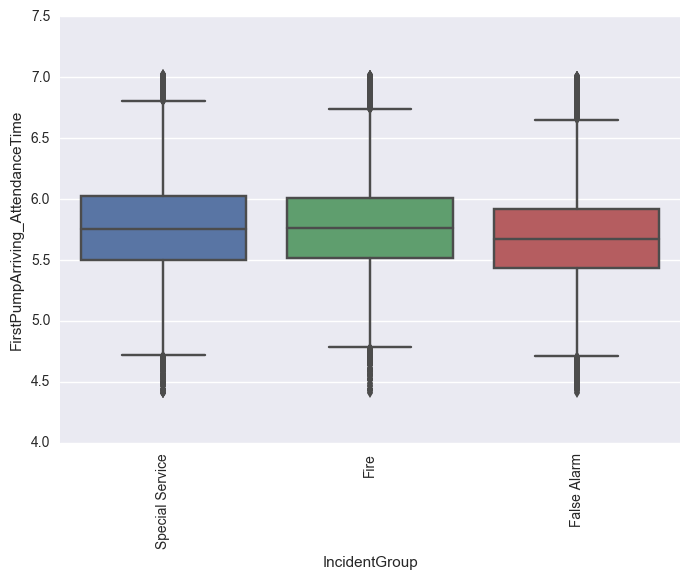

FirstPumpArriving_AttendanceTime StopCodeDescription
ANOVA 252.087531573 0.0
['AFA' 'Chimney Fire' 'False alarm - Good intent' 'False alarm - Malicious'
 'Late Call' 'Primary Fire' 'Secondary Fire' 'Special Service']
                 Multiple Comparison of Means - Tukey HSD,FWER=0.05                
          group1                    group2          meandiff  lower   upper  reject
-----------------------------------------------------------------------------------
           AFA                   Chimney Fire        0.3065   0.0561  0.5569  True 
           AFA            False alarm - Good intent  0.0914   0.0781  0.1047  True 
           AFA             False alarm - Malicious   0.0785   0.0501  0.1069  True 
           AFA                    Late Call          0.2029   0.0524  0.3534  True 
           AFA                   Primary Fire        0.0743   0.0607  0.0879  True 
           AFA                  Secondary Fire       0.1436   0.1306  0.1566  True 
           AFA             

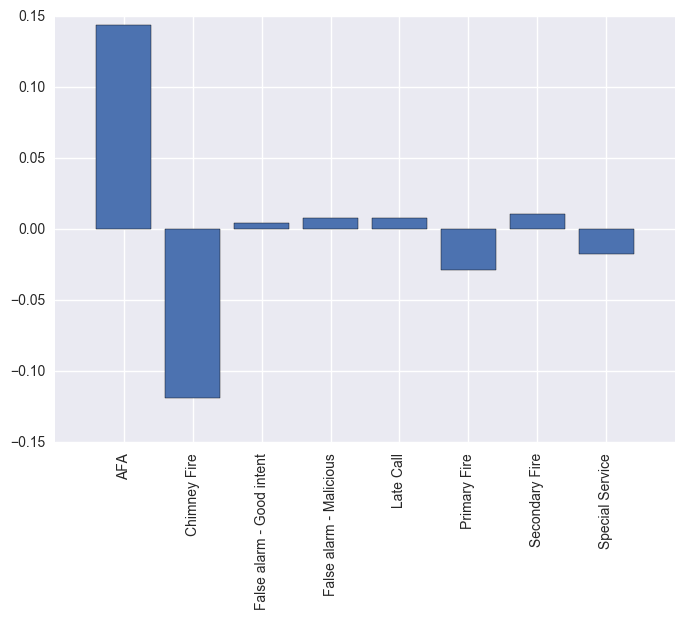

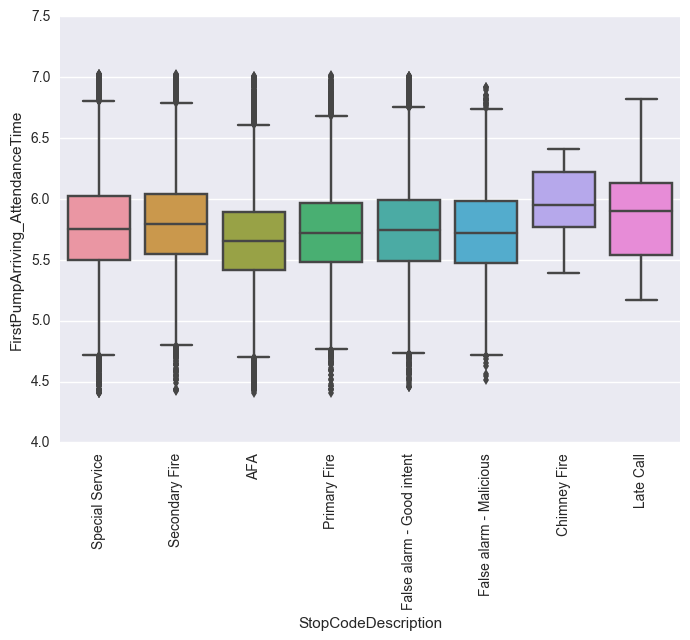

FirstPumpArriving_AttendanceTime PropertyCategory
ANOVA 297.56115847 0.0
unorderable types: str() > float()
FirstPumpArriving_AttendanceTime AddressQualifier
ANOVA 235.516261765 0.0
['Correct incident address' 'In street close to' 'In street outside'
 'In street remote from postal address'
 'Nearby address - no building in street'
 'Nearby address - street not listed' 'On land associated with building'
 'On motorway / elevated road'
 'Open land/water - nearest address to access'
 'Railway land or rolling stock' 'Within same building']
                                   Multiple Comparison of Means - Tukey HSD,FWER=0.05                                  
                   group1                                      group2                   meandiff  lower   upper  reject
-----------------------------------------------------------------------------------------------------------------------
          Correct incident address                       In street close to              0.0767   0

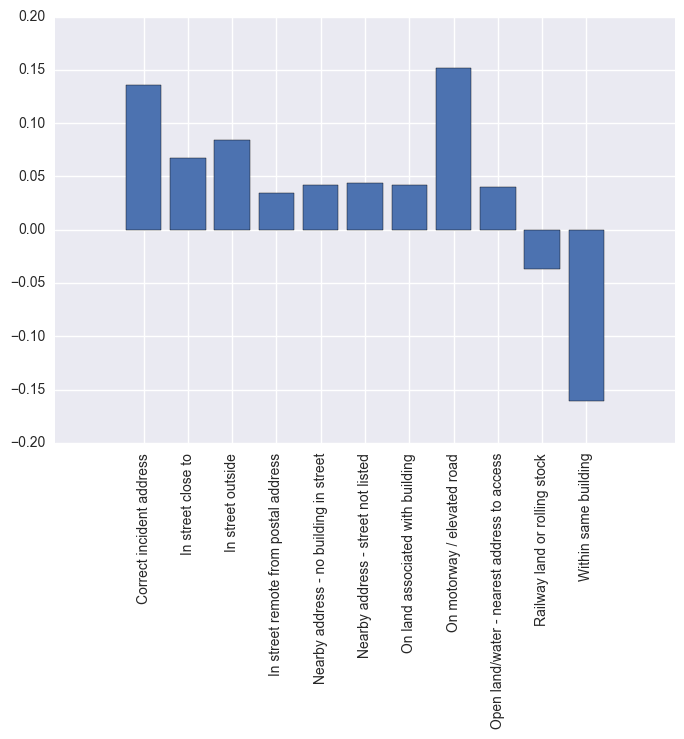

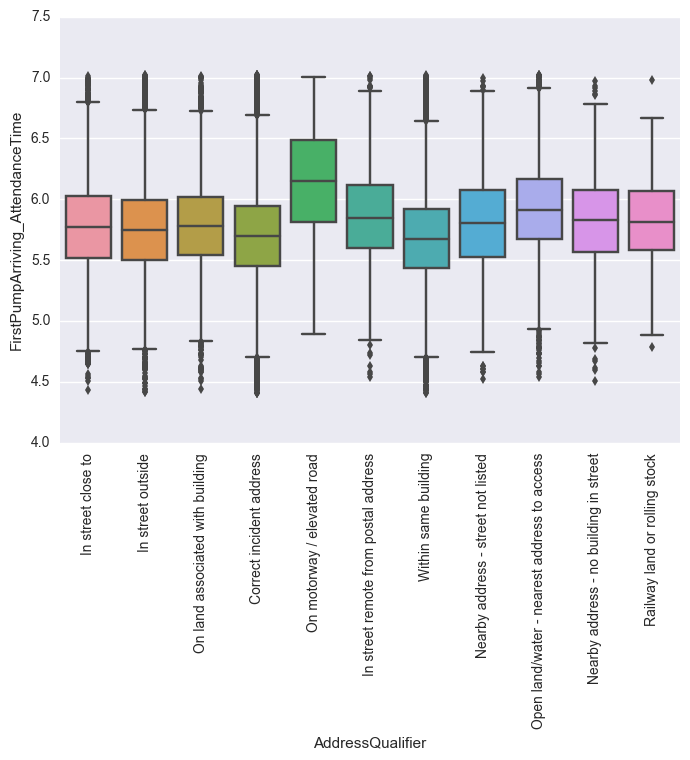

FirstPumpArriving_AttendanceTime Postcode_district
ANOVA 166.706527864 0.0
['CR0' 'E1' 'E14' 'E15' 'E17' 'E2' 'E3' 'E8' 'N1' 'NW1' 'NW10' 'NW3' 'SE1'
 'SE15' 'SE18' 'SE5' 'SW6' 'W12' 'W2' 'other']
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 CR0     E1   -0.2471  -0.2959 -0.1982  True 
 CR0    E14   -0.1312  -0.1826 -0.0798  True 
 CR0    E15    -0.22    -0.28   -0.16   True 
 CR0    E17    0.0322   -0.026  0.0904 False 
 CR0     E2   -0.1894   -0.247 -0.1318  True 
 CR0     E3   -0.1282  -0.1857 -0.0707  True 
 CR0     E8   -0.1221  -0.1836 -0.0606  True 
 CR0     N1   -0.1271  -0.1791  -0.075  True 
 CR0    NW1   -0.1072  -0.1573 -0.0571  True 
 CR0    NW10  -0.0198  -0.0766  0.037  False 
 CR0    NW3   -0.1057  -0.1626 -0.0488  True 
 CR0    SE1   -0.3213  -0.3689 -0.2737  True 
 CR0    SE15  -0.2119  -0.2684 -0.1553  True 
 CR0    SE18  -0.0911  -0.1475 -0.0346  True 
 CR0    SE5   -0

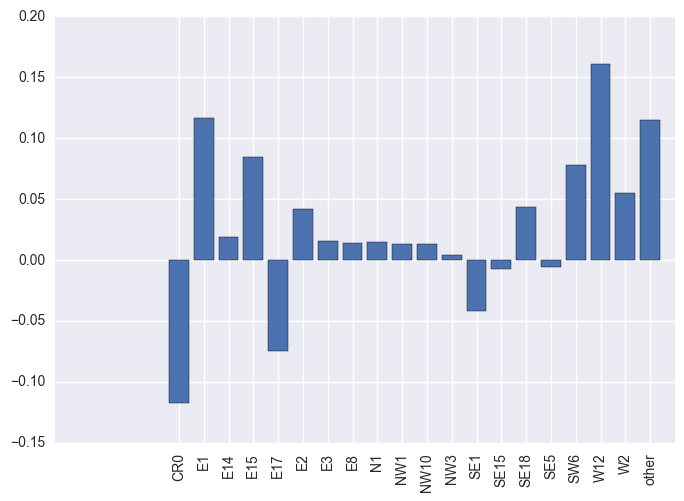

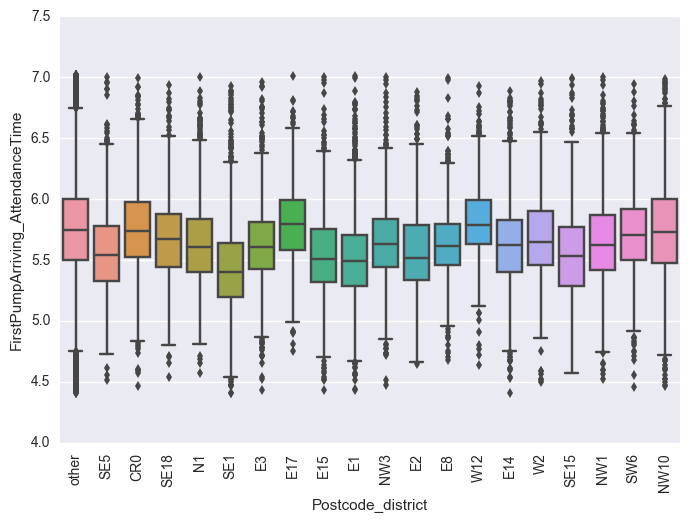

FirstPumpArriving_AttendanceTime IncGeo_BoroughName
ANOVA 372.373656167 0.0
['Barnet' 'Brent' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich'
 'Hackney' 'Hammersmith and Fulham' 'Hillingdon' 'Islington'
 'Kensington and Chelsea' 'Lambeth' 'Lewisham' 'Newham' 'Southwark'
 'Tower Hamlets' 'Wandsworth' 'Westminster' 'other']
              Multiple Comparison of Means - Tukey HSD,FWER=0.05             
        group1                 group2         meandiff  lower   upper  reject
-----------------------------------------------------------------------------
        Barnet                 Brent          -0.0434  -0.0804 -0.0065  True 
        Barnet                 Camden         -0.2711  -0.3026 -0.2396  True 
        Barnet                Croydon         -0.0907  -0.1263 -0.0551  True 
        Barnet                 Ealing         -0.0942  -0.1295 -0.0589  True 
        Barnet                Enfield          0.0537   0.0178  0.0895  True 
        Barnet               Greenwich        -0.1

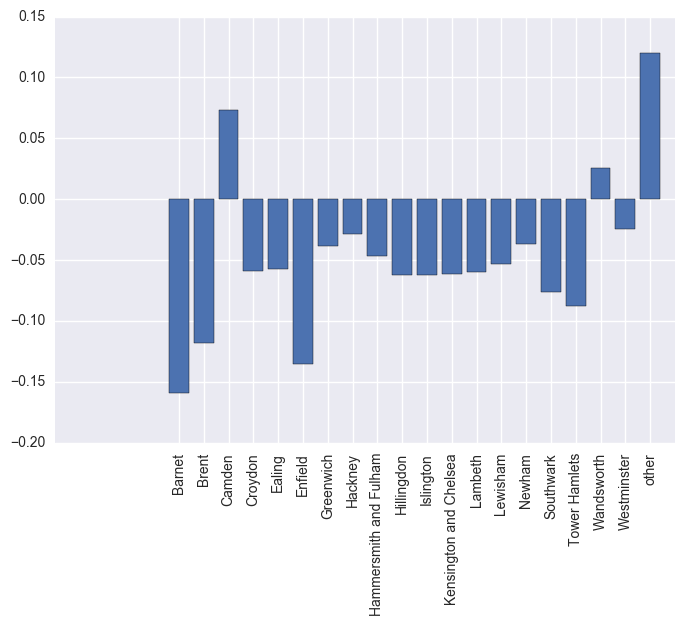

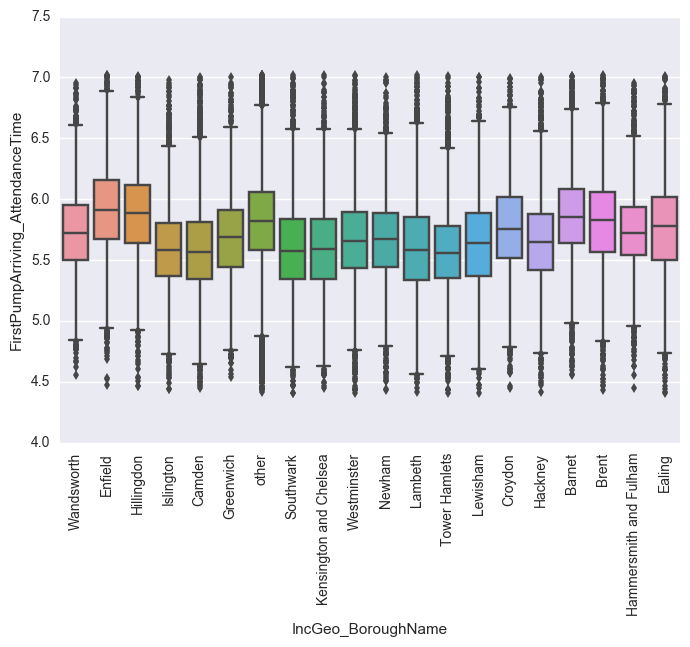

FirstPumpArriving_AttendanceTime IncGeo_WardName
ANOVA 141.543702463 0.0
['Beckton' 'Bethnal Green South' "Bishop's" 'Bloomsbury' 'Bunhill'
 'Cathedrals' 'Chatham' 'Fairfield' 'Hampstead Town' 'Heathrow Villages'
 'Holborn and Covent Garden' 'Marylebone High Street'
 'Mile End and Globe Town' 'Millwall' "Regent's Park" "St James's"
 'Village' 'West End' 'Whitechapel' 'other']
                 Multiple Comparison of Means - Tukey HSD,FWER=0.05                
          group1                    group2          meandiff  lower   upper  reject
-----------------------------------------------------------------------------------
         Beckton             Bethnal Green South    -0.2191   -0.317 -0.1212  True 
         Beckton                   Bishop's         -0.3018  -0.3994 -0.2043  True 
         Beckton                  Bloomsbury        -0.1872  -0.2717 -0.1026  True 
         Beckton                   Bunhill           -0.231  -0.3258 -0.1361  True 
         Beckton                 

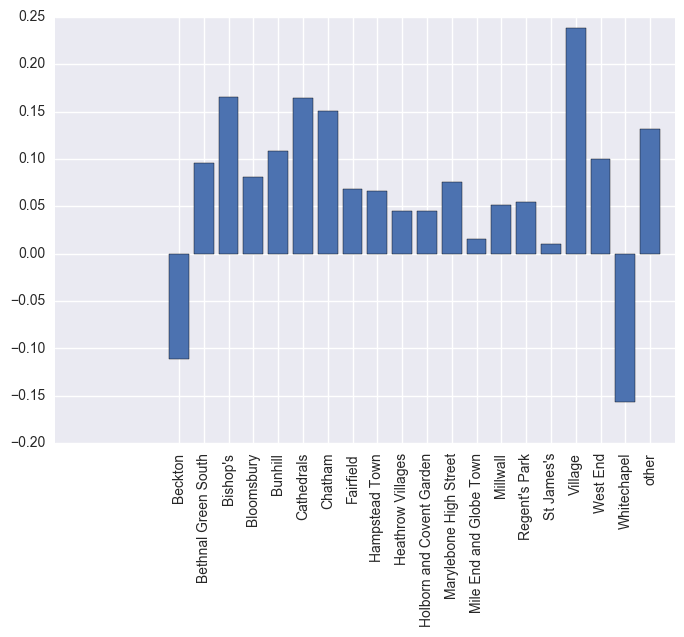

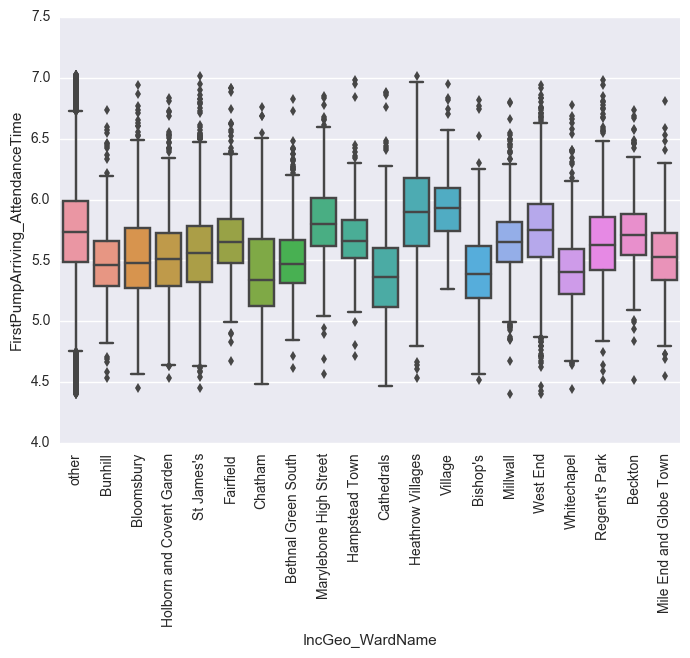

FirstPumpArriving_AttendanceTime IncidentStationGround
ANOVA 186.517305948 0.0
['Bethnal Green' 'Brixton' 'Clerkenwell' 'Dagenham' 'Edmonton' 'Enfield'
 'Euston' 'Hammersmith' 'Homerton' 'Ilford' 'North Kensington' 'Paddington'
 'Peckham' 'Poplar' 'Soho' 'Southwark' 'Stoke Newington' 'Tottenham'
 'Westminster' 'other']
        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1           group2      meandiff  lower   upper  reject
-----------------------------------------------------------------
 Bethnal Green       Brixton      -0.0154   -0.069  0.0383 False 
 Bethnal Green     Clerkenwell    -0.0396  -0.0889  0.0096 False 
 Bethnal Green       Dagenham      0.2558   0.2045  0.3071  True 
 Bethnal Green       Edmonton      0.3056   0.2522  0.3591  True 
 Bethnal Green       Enfield       0.3783   0.3246  0.432   True 
 Bethnal Green        Euston       0.0383  -0.0086  0.0852 False 
 Bethnal Green     Hammersmith     0.1822   0.1321  0.2323  True 
 Bethnal Green     

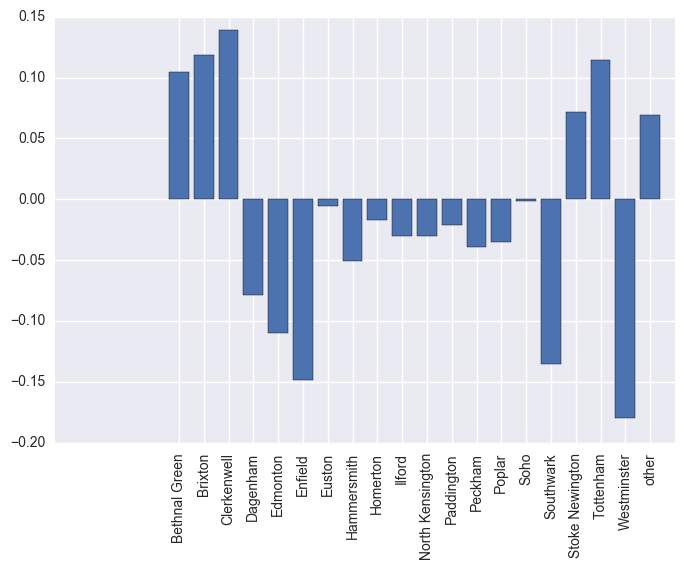

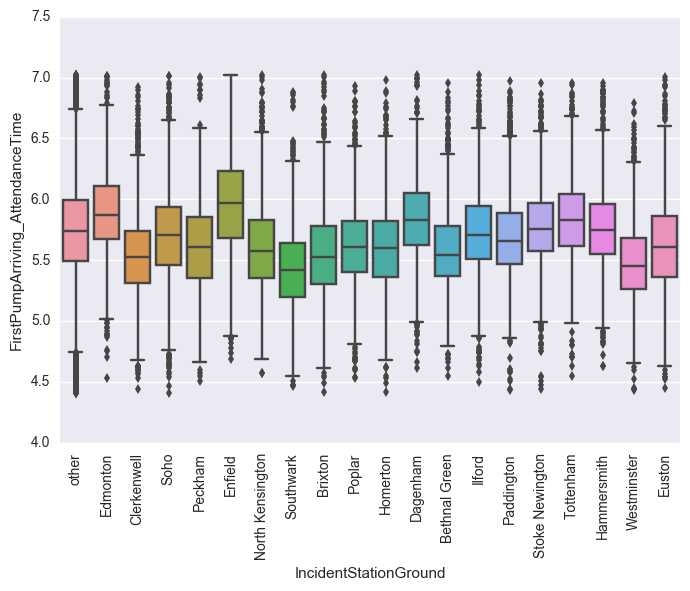

FirstPumpArriving_AttendanceTime FirstPumpArriving_DeployedFromStation
ANOVA 153.840059482 0.0
['Bethnal Green' 'Brixton' 'Clerkenwell' 'Dagenham' 'Enfield' 'Euston'
 'Hammersmith' 'Homerton' 'Ilford' 'Kentish Town' 'Lambeth'
 'North Kensington' 'Paddington' 'Peckham' 'Poplar' 'Soho' 'Stratford'
 'Tottenham' 'West Hampstead' 'other']
        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1           group2      meandiff  lower   upper  reject
-----------------------------------------------------------------
 Bethnal Green       Brixton       0.0281  -0.0276  0.0838 False 
 Bethnal Green     Clerkenwell    -0.0033  -0.0557  0.0491 False 
 Bethnal Green       Dagenham      0.305    0.2514  0.3586  True 
 Bethnal Green       Enfield       0.4012   0.3451  0.4574  True 
 Bethnal Green        Euston       0.0513   0.0012  0.1015  True 
 Bethnal Green     Hammersmith     0.2317   0.1805  0.2829  True 
 Bethnal Green       Homerton      0.0619   0.0075  0.1163  True 
 Bet

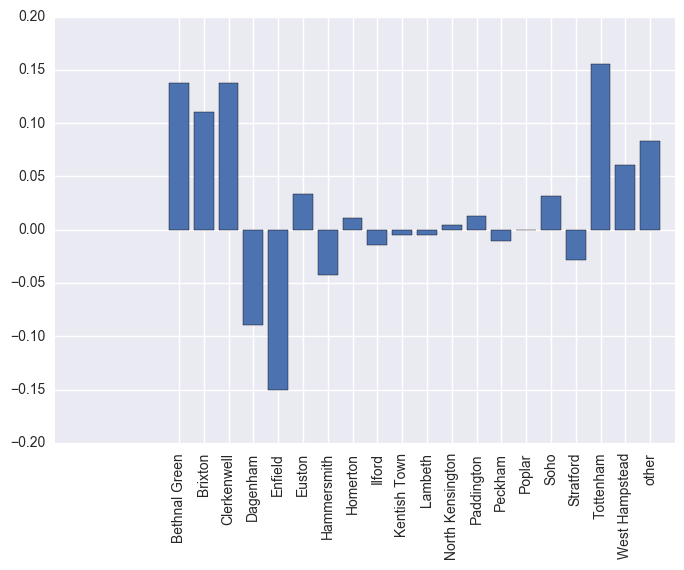

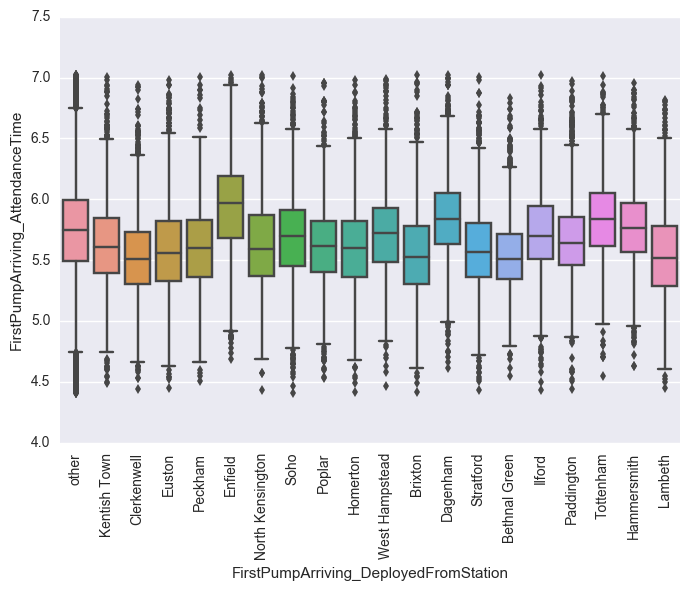

FirstPumpArriving_AttendanceTime SecondPumpArriving_DeployedFromStation
ANOVA 157.793005953 0.0
['Brixton' 'Chelsea' 'Dagenham' 'Hammersmith' 'Homerton' 'Ilford'
 'Kentish Town' 'Lambeth' 'North Kensington' 'Old Kent Road' 'Paddington'
 'Peckham' 'Soho' 'Stoke Newington' 'Tooting' 'Tottenham' 'Wandsworth'
 'West Hampstead' 'Whitechapel' 'other']
        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1           group2      meandiff  lower   upper  reject
-----------------------------------------------------------------
    Brixton          Chelsea       0.0791  -0.0032  0.1614 False 
    Brixton          Dagenham      0.3589   0.273   0.4448  True 
    Brixton        Hammersmith     0.2375    0.16   0.315   True 
    Brixton          Homerton      0.0311  -0.0522  0.1144 False 
    Brixton           Ilford       0.2438   0.162   0.3256  True 
    Brixton        Kentish Town    0.0492  -0.0358  0.1341 False 
    Brixton          Lambeth      -0.0616  -0.1421  0.0188

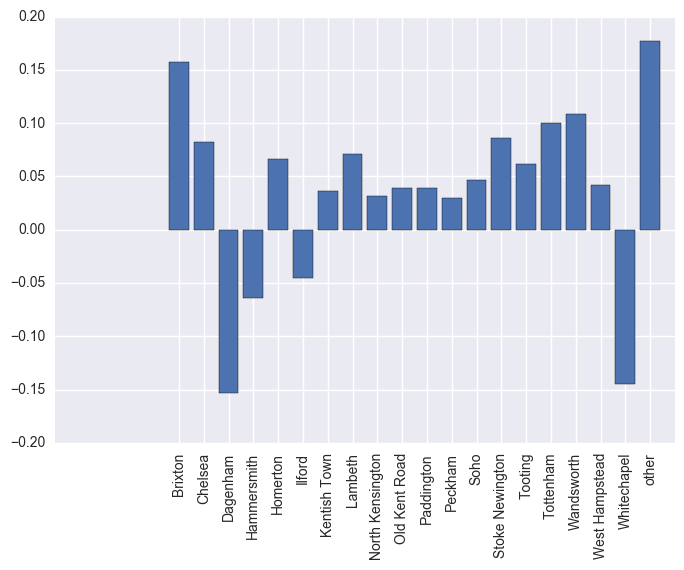

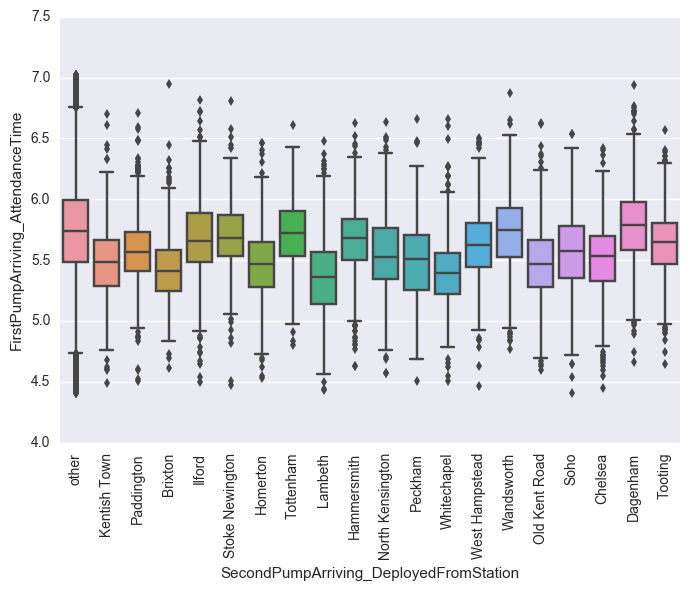

In [23]:
def boxplotcats(df, c2, catcols=catcols):
    for c in catcols:
        if(len(onehotencodings[c]) < 100):
            #df_sub = inverseonehotencode(df, c,onehotencodings[c])
            _ = sns.boxplot(x=c, y=c2, data=df)
            _ = plt.xticks(rotation=90)
            plt.show()

def inverseonehotencode(df, col, cols):
    df2 = df.copy(deep=True)
    x = df2[cols].stack()
    s = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))
    df2[col] = s
    df2 = df2.drop(cols, axis=1)
    #print(s)
    return df2

#print(df.head())
#print(inverseonehotencode(df, catcols[0],onehotencodings[catcols[0]]).head())
#shall I do a clustering on the pump arrival times? 
#arrival times vs station?
c2 = "FirstPumpArriving_AttendanceTime"

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

#t test means of data across category
for c in catcols:
    try:
        print(c2, c)
        p_vals = []
        labels = []
        sub_values = []
        for c_sub1 in onehotencodings[c]:
            sub_values.append(list(df[df[c_sub1] == 1][c2].values))
        #print(sub_values)
        #print(sub_values)
        #ANOVA test 1 way
        stat, pval = sp.stats.f_oneway(*sub_values)
        print("ANOVA", stat, pval)
        #df_sub = inverseonehotencode(df, c, onehotencodings[c])
        #print(df_sub[c].head())
        #print(df_sub[c2].head())
        mod = MultiComparison(df[c2], df[c])
        tukey = mod.tukeyhsd()
        print(mod.groupsunique)
        #print()
        #print(tukey.meandiffs)
        print (tukey)
        combs = list(itertools.combinations(mod.groupsunique, 2))
        #print(len(combs))
        ave_means = [];
        for d in mod.groupsunique:
            #print(d)
            sum_means = 0;
            count_means = 0;
            for i in range(len(combs)):
                #print(d, i)
                a, b = combs[i]
                if(a == d or b == d):
                    sum_means += tukey.meandiffs[i]
                    count_means += 1
            ave_means.append(sum_means/count_means)
        #print(ave_means, np.arange(len(mod.groupsunique)))
        _ = plt.bar(np.arange(len(mod.groupsunique)), ave_means, align='center')
        _ = plt.xticks(np.arange(len(mod.groupsunique)), mod.groupsunique)
        _ = plt.xticks(rotation=90)
        _ = plt.show()
        boxplotcats(df, c2, catcols=[c])
       
    except Exception as e: 
        print (str(e))
    #for c_sub1 in onehotencodings[c]:
    #    sub1 = df[df[c_sub1] == 1][c2].values
    #    sub1_not = df[df[c_sub1] == 0][c2].values
    #    #Welch's t-test
    #    _, p_val = sp.stats.ttest_ind(sub1, sub1_not, equal_var = False)
    #    sig = p_val < 0.05
    #    p_vals.append(p_val)
    #    labels.append(c_sub1)
    #    print(c_sub1, "{:1.4f}".format(p_val), "Sig=", sig, "sub1mean=", sub1.mean(), "sub2mean=", sub1_not.mean())
    #plot_catmatrix(np.matrix([p_vals]), labels, [c2], normalize=False, y_title=c2, x_title=c)




## Plot 2 numerical - not used

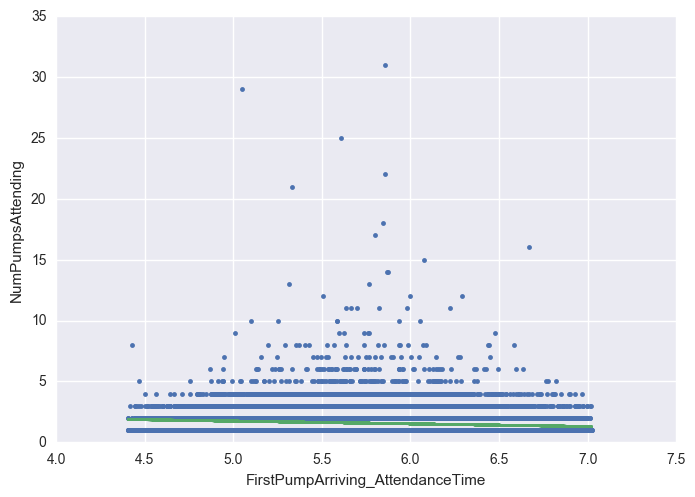

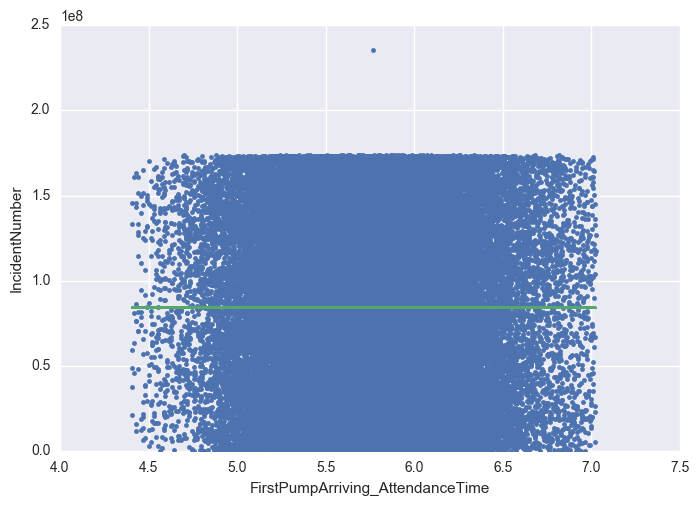

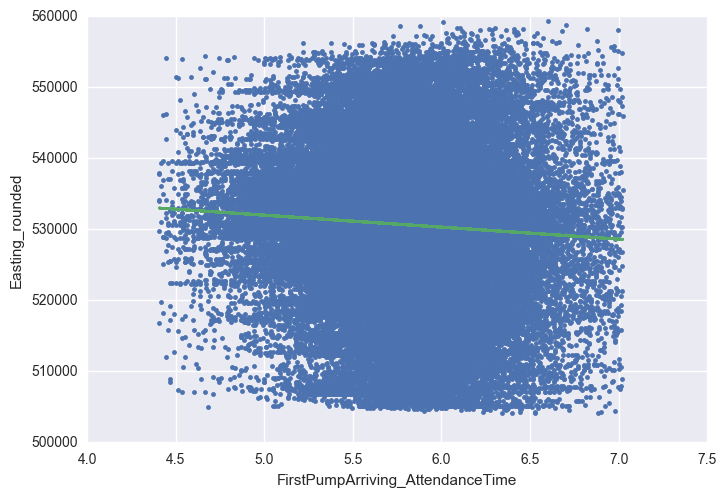

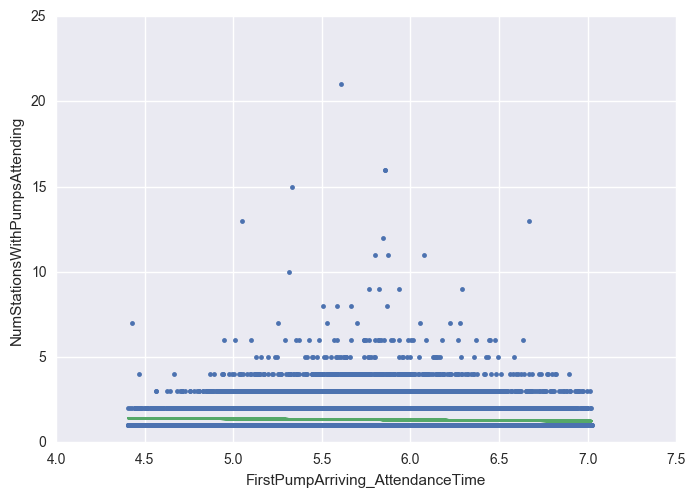

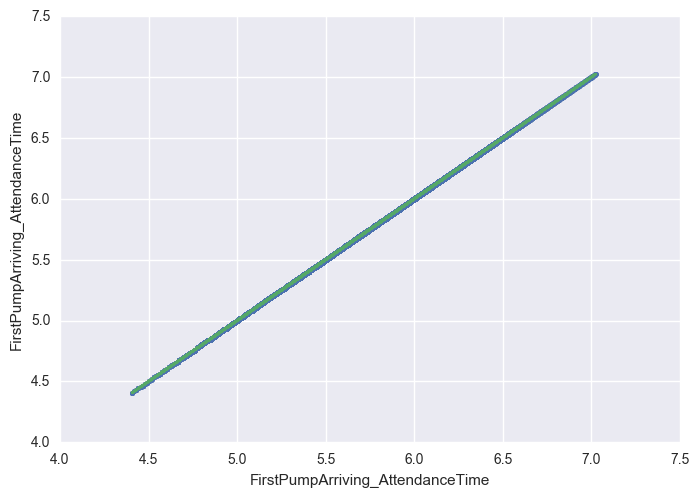

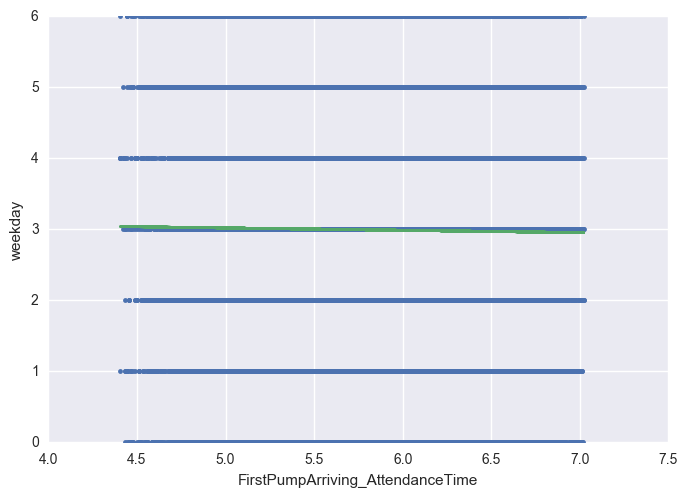

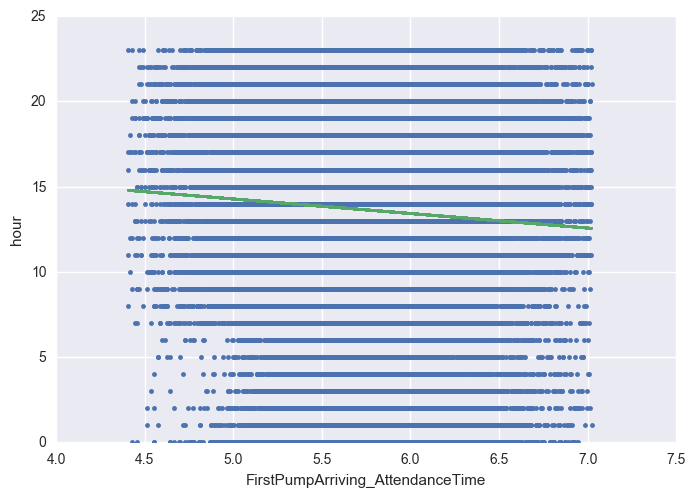

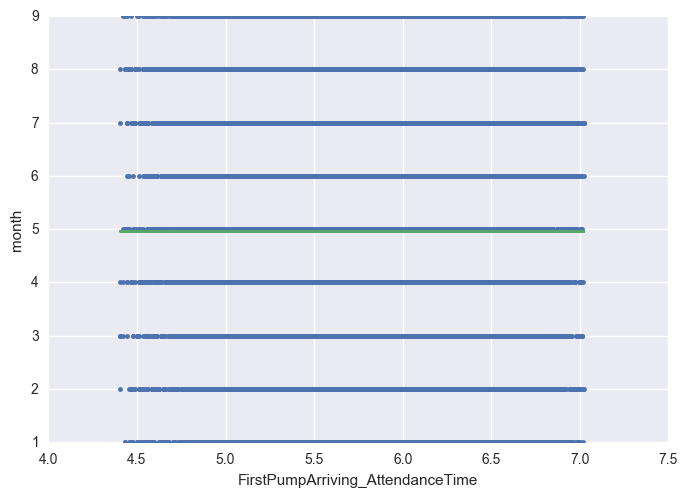

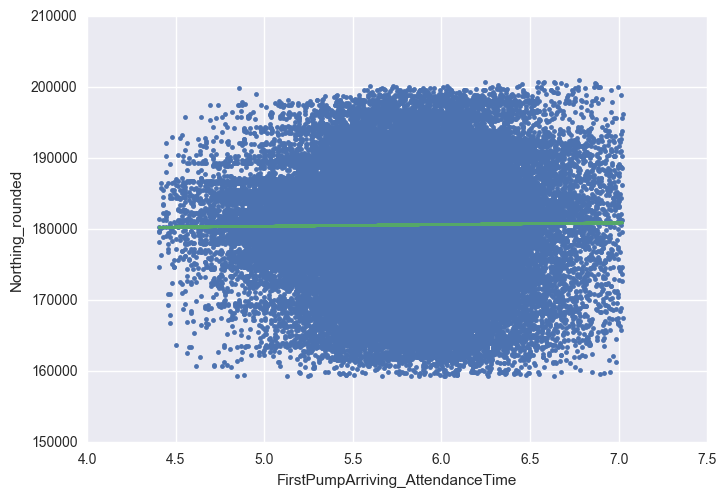

In [24]:
def plot2numerical(df_temp, c1, c2):
    x = df_temp[c1]
    y = df_temp[c2]
    # fit with np.polyfit
    m, b = np.polyfit(x, y, 1)

    plt.figure()
    plt.plot(x, y, '.')
    plt.plot(x, m*x + b, '-')
    plt.xlabel(c1)
    plt.ylabel(c2)
    plt.show()

for c in numcolsexOH:
    plot2numerical(df_temp, c2, c)

## Plot categories vs 2 numerical - not used

{'IncidentStationGround': ['IncidentStationGround_Homerton', 'IncidentStationGround_Tottenham', 'IncidentStationGround_Soho', 'IncidentStationGround_other', 'IncidentStationGround_Bethnal Green', 'IncidentStationGround_Peckham', 'IncidentStationGround_Westminster', 'IncidentStationGround_North Kensington', 'IncidentStationGround_Clerkenwell', 'IncidentStationGround_Ilford', 'IncidentStationGround_Edmonton', 'IncidentStationGround_Paddington', 'IncidentStationGround_Hammersmith', 'IncidentStationGround_Stoke Newington', 'IncidentStationGround_Dagenham', 'IncidentStationGround_Poplar', 'IncidentStationGround_Brixton', 'IncidentStationGround_Enfield', 'IncidentStationGround_Southwark', 'IncidentStationGround_Euston'], 'AddressQualifier': ['AddressQualifier_On land associated with building', 'AddressQualifier_In street outside', 'AddressQualifier_Railway land or rolling stock', 'AddressQualifier_On motorway / elevated road', 'AddressQualifier_In street close to', 'AddressQualifier_Correct 

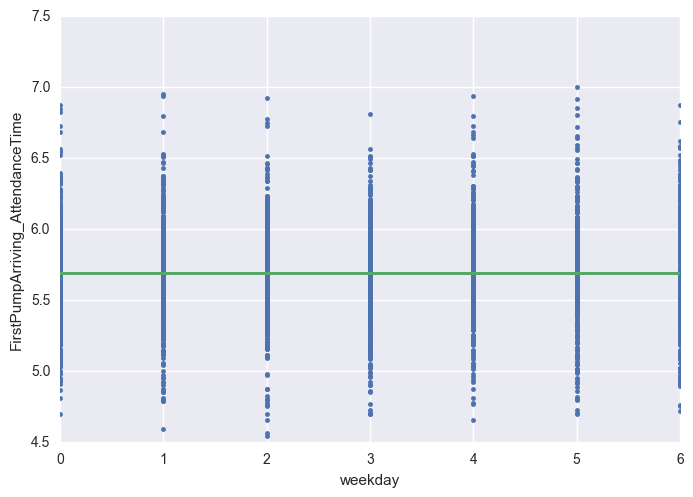

IncGeo_BoroughName_Camden


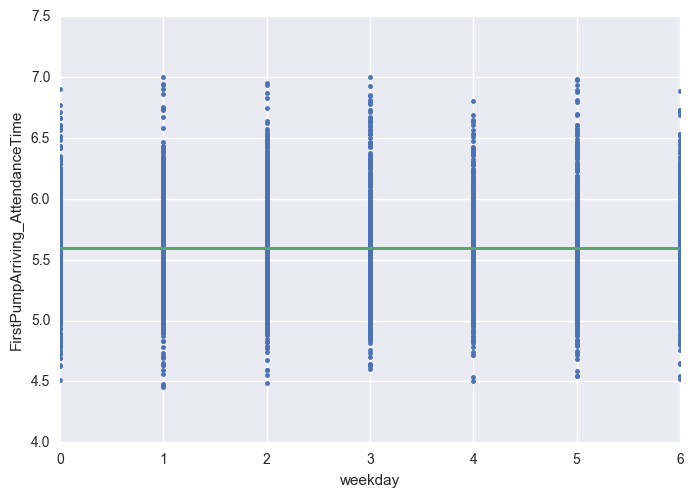

IncGeo_BoroughName_Enfield


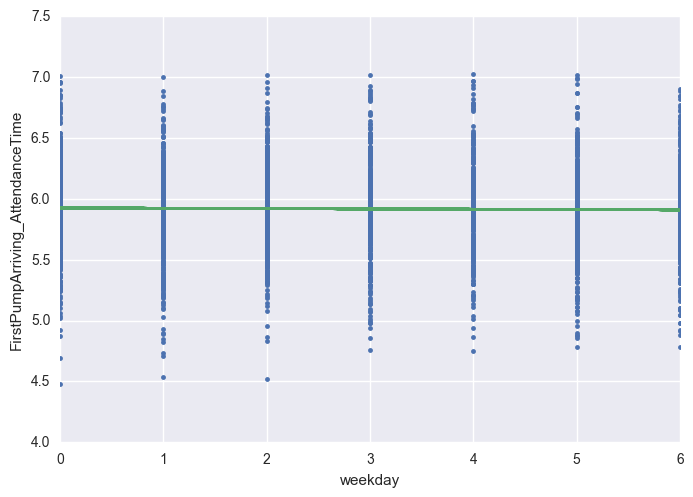

IncGeo_BoroughName_Kensington and Chelsea


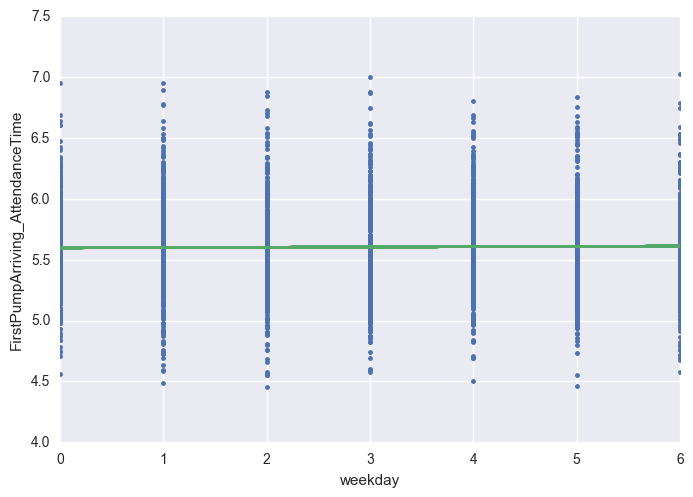

IncGeo_BoroughName_other


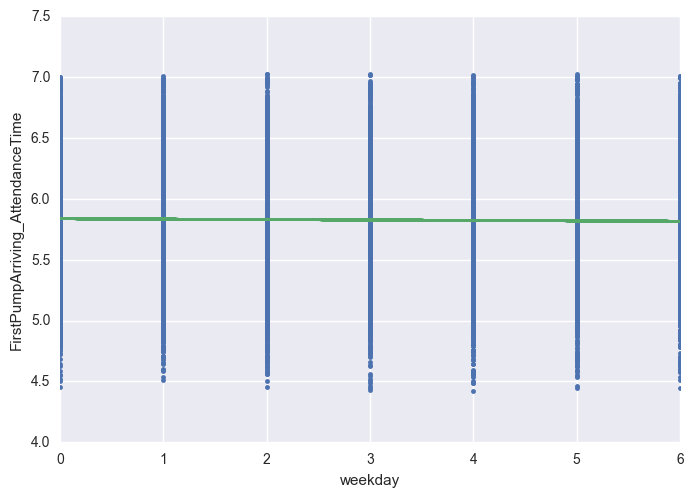

IncGeo_BoroughName_Croydon


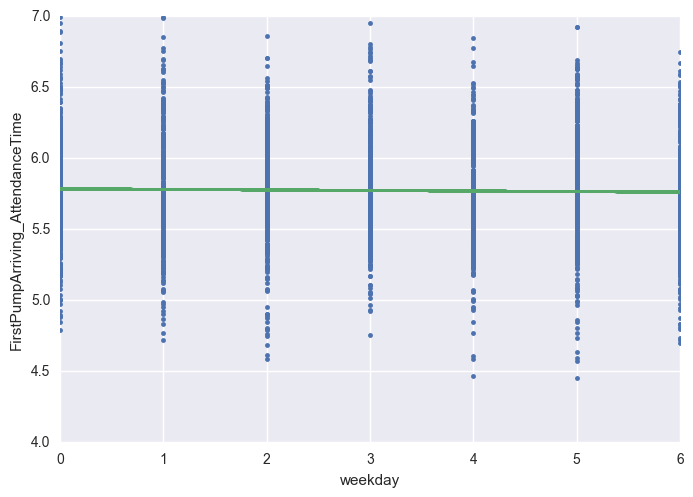

IncGeo_BoroughName_Westminster


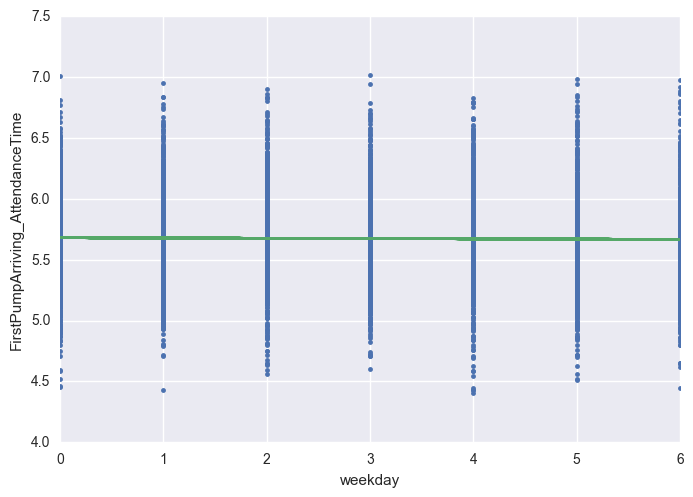

IncGeo_BoroughName_Lewisham


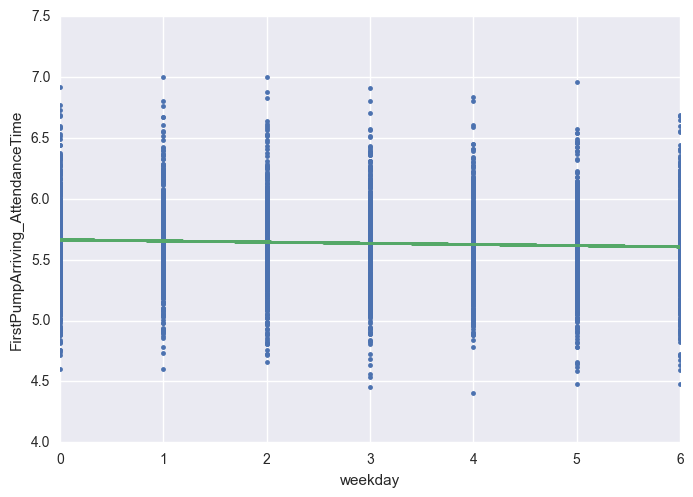

IncGeo_BoroughName_Newham


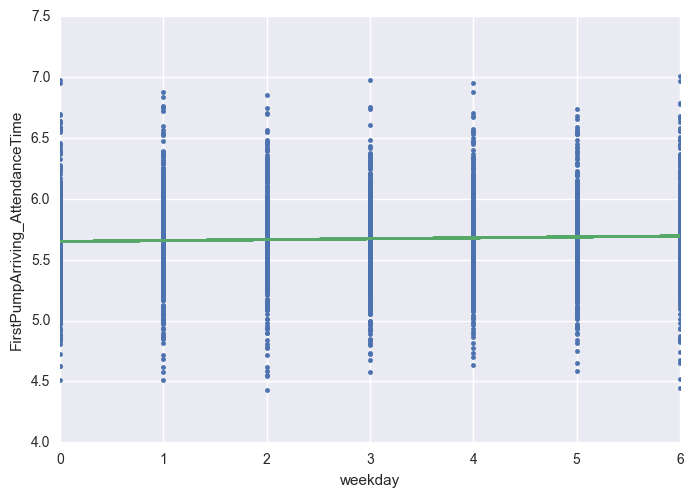

IncGeo_BoroughName_Hammersmith and Fulham


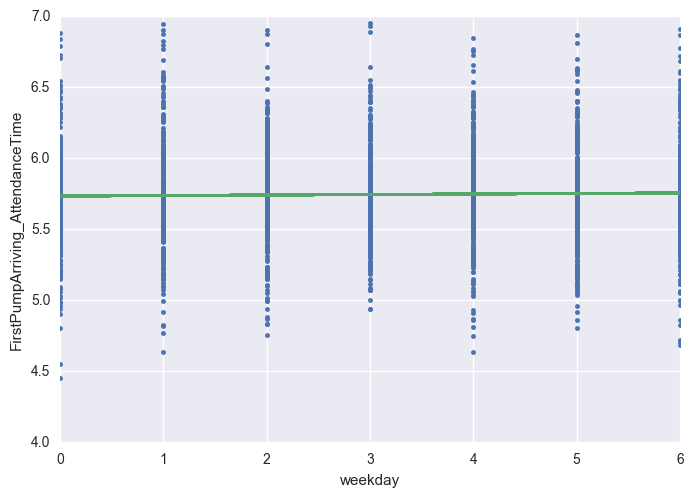

IncGeo_BoroughName_Barnet


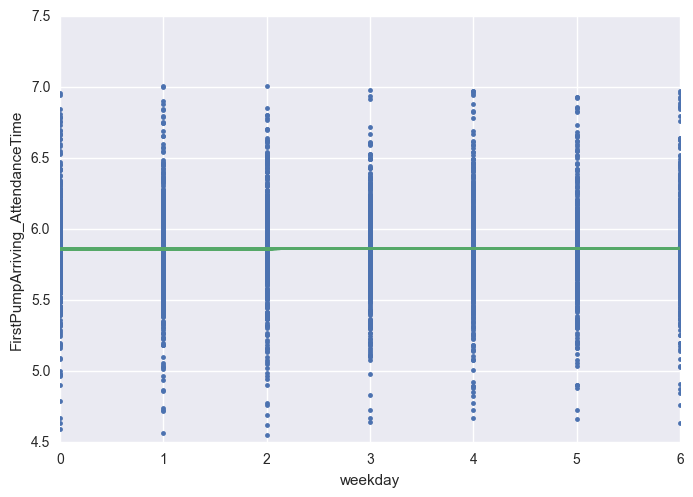

IncGeo_BoroughName_Southwark


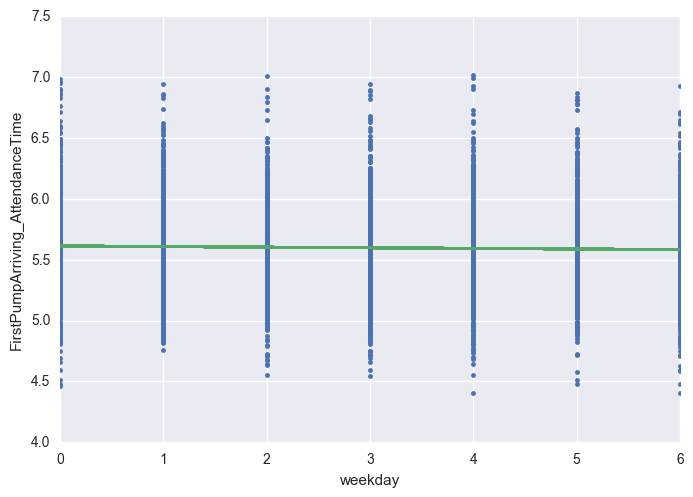

IncGeo_BoroughName_Hillingdon


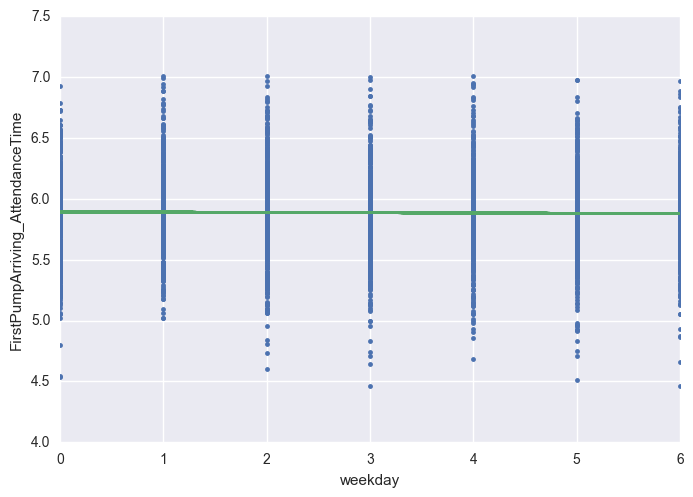

IncGeo_BoroughName_Islington


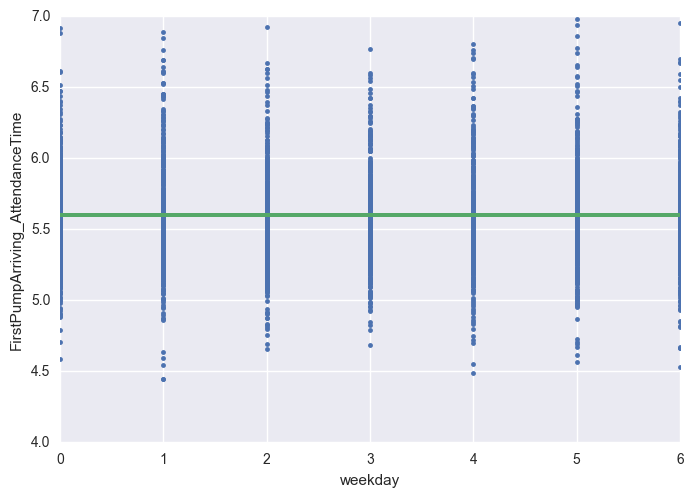

IncGeo_BoroughName_Lambeth


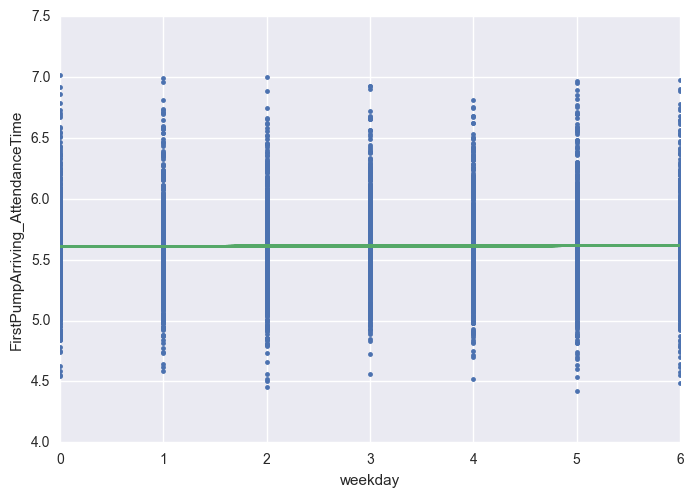

IncGeo_BoroughName_Brent


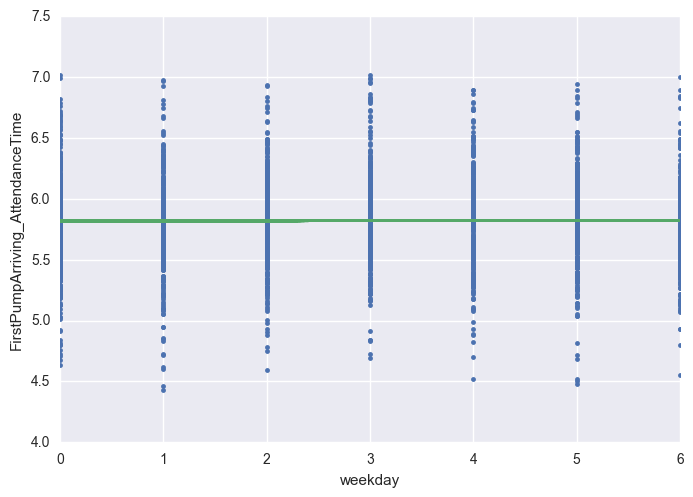

IncGeo_BoroughName_Tower Hamlets


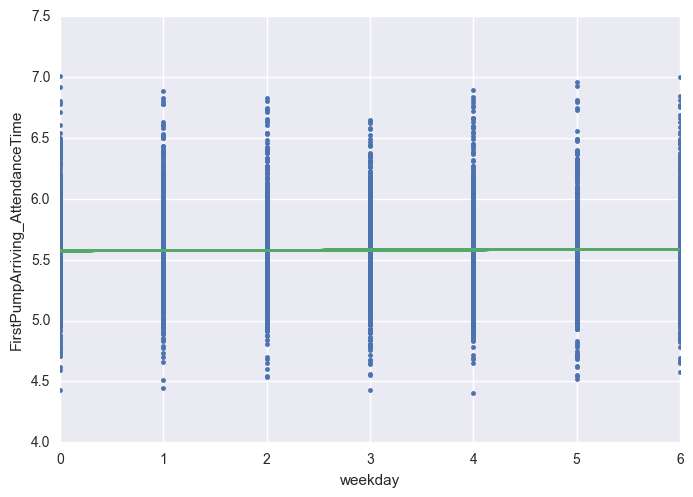

IncGeo_BoroughName_Hackney


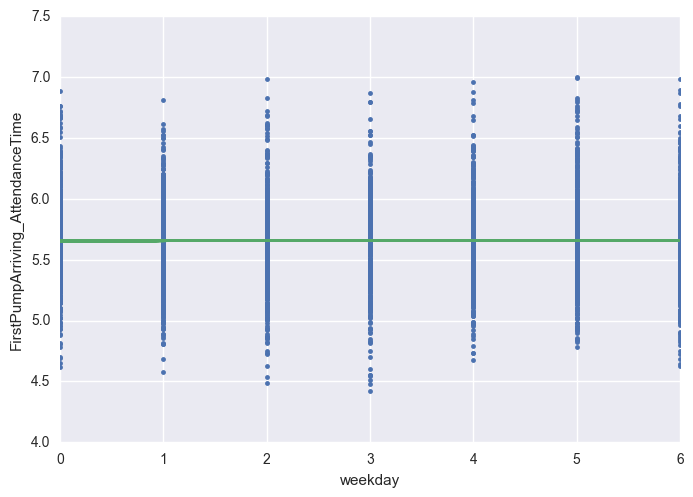

IncGeo_BoroughName_Wandsworth


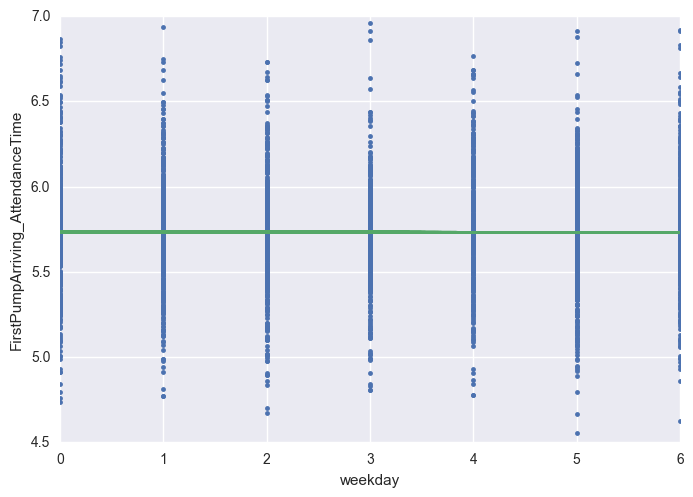

IncGeo_BoroughName_Ealing


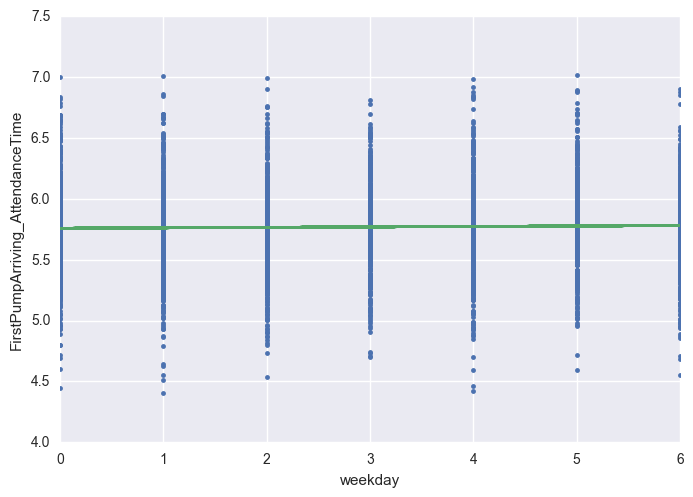

In [25]:
#hour vs pump arrival time
# for each category in BoroughName
c2 = "FirstPumpArriving_AttendanceTime"
c1 = "weekday"
c3 = "IncGeo_BoroughName"
print(onehotencodings)
for c in onehotencodings[c3]:
    #print(c)
    df_temp2 = df_temp[df_temp[c].apply(lambda x: x == 1)]
    plot2numerical(df_temp2, c1, c2)

## Now do a random forest to see what affects dependent var 

In [26]:
def mse(pred, act):
    diff = np.mean(np.power(pred-act, 2))
    return diff

def oneRF(df, c_xs, c_y):
    #print(c_xs, c_y)
    x1 = df[c_xs].values
    y1 = df[c_y].values.reshape(-1, 1)
    #print(x1)
    #print(y1)
    #normalise the data
    scaler = StandardScaler()
    x1 = scaler.fit_transform(x1)
    #x2 = scaler.transform(x2)
    sv = RandomForestRegressor()
    
    estimators = []
    estimators.append(("RF", sv))
    model = Pipeline(estimators)
    param_rf = {"RF__max_depth": [3],
              #"RF__max_features": [1, 3],
              "RF__min_samples_split": [ 3],
              "RF__min_samples_leaf": [3],
              "RF__bootstrap": [True, False],
               }
    
    cv_splits = 2
   
   
    svm = GridSearchCV(model, cv=cv_splits, param_grid=param_rf)
    svm.fit(x1, y1)
    y1_pred = svm.predict(x1)
    s_in = mse(y1_pred, np.squeeze(y1))
    #s_out = svm.score(x2, y2)
    return s_in

In [ ]:
c2 = "FirstPumpArriving_AttendanceTime"
#finding the best predictor of c2

iteration = 0
colsleft = numcols
colsincluded = []
total_mse = []
iteration_list = [];
#picker doesn't quite seem to be doing as good a job as all columns
while(iteration < 160):
    res_list = []
    if(len(colsleft) == 0):
        break
    print("iteration", iteration)
    print("colsleft", len(colsleft))
    acc = 0;
    for c in colsleft:
        if(not c == c2):
            temp_cols = colsincluded + [c]
            #print(temp_cols)
            s_in = oneRF(df, temp_cols, c2)
            res_list.append({"col": c, "s_in": s_in})
            acc +=1
            print("("+str(acc)+")", s_in, end="")

    res = pd.DataFrame(res_list)
    res = res.sort_values(["s_in"])
    #res = res.reindex(range(0, len(res)))
    print(res.head())
    #---------------------------------------
    # select best k columns
    #---------------------------------------
    for i in range(20):
        if(len(res) > 0):
            bestcol = res["col"].iloc[0]
            print("BEST COLUMN ", bestcol)
            res = res.drop(res.index[0])
            colsincluded.append(bestcol)
    
    s_cur = oneRF(df, colsincluded, c2)
    iteration_list.append(iteration)
    total_mse.append(s_cur)
    
    colsleft = res["col"].values
    iteration+=1

Fit benchmark of all columns


160 0.139749938768
159 0.139834166917


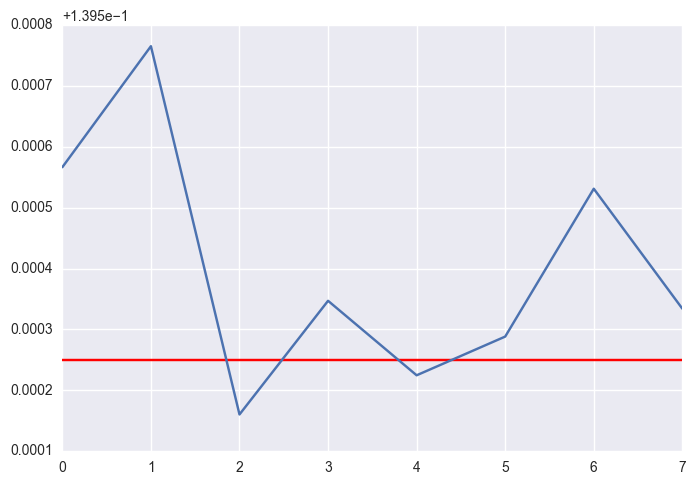

In [44]:
print("Fit benchmark of all columns")
#calc with all columns in it
numcolsexc2 = list(set(numcols)- set([c2]))
s_in_max = oneRF(df, numcolsexc2, c2)
horiz_line_data = [iteration_list[0], iteration_list[-1]]
plt.plot( horiz_line_data,[s_in_max, s_in_max], 'r') 

plt.plot(iteration_list, total_mse)
print(len(numcols), s_in_max)
print(len(colsincluded), total_mse[-1])
plt.show()

#might not use this function
def dorandtes():    
    randtests = 10
    randdf = pd.DataFrame(np.random.randint(0,100,size=(df.shape[0], randtests)))
    randdf[c2] = df[c2]
    print(randdf.head())
    randlist = []
    for c in randdf.columns:
        s_in = oneRF(randdf, [c], c2)
        randlist.append(s_in)

    mean = np.mean(randlist)
    std = np.std(randlist)
    up_limit = mean + 2* std
    low_limit = mean - 2* std
    res_list.append({"col": "up_rand", "s_in": up_limit})
    res_list.append({"col": "mean_rand", "s_in": mean})
    res_list.append({"col": "low_rand", "s_in": low_limit})
    

# Presentation
-------
1. General thoughts on the dataset
2. Specific question
* Is BLM charging the right amount vs man hours?
3. What data do we have to answer that question?
4. What data we use? high correlation
5. LR of man hours vs charge
6 Look at LR with groupings of different case types


160 0.139935311709
159 0.139834166917


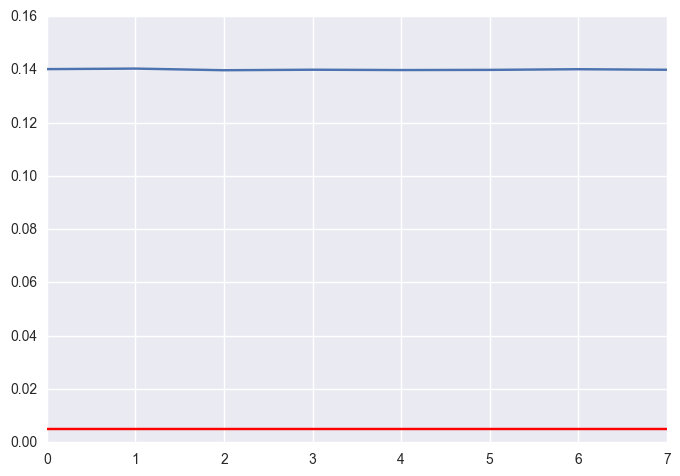

In [43]:
print(len(numcols), s_in_max)
print(len(colsincluded), total_mse[-1])
s_in_max = oneRF(df, numcols, c2)
horiz_line_data = [iteration_list[0], iteration_list[-1]]
plt.plot( horiz_line_data,[s_in_max, s_in_max], 'r') 

plt.plot(iteration_list, total_mse)
plt.show()